In [354]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import py
import pandas as pd
import seaborn as sns
from collections import OrderedDict
import glob
import os
import re
from IPython.display import FileLink
import pyprind
from khmer import Countgraph
from khmer._oxli.partitioning import StreamingPartitioner, Component
from khmer._oxli.traversal import Traverser
from khmer._oxli.hashing import Kmer
from khmer._oxli.app import PartitioningApp
from khmer import reverse_hash
import json
import cython
import cythonmagic
import networkx as nx
from khmer import reverse_complement

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext cython

/home/camille/miniconda/envs/dev.py3.khmer.assembly/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


In [3]:
sns.set_style('ticks')

In [4]:
sp = StreamingPartitioner.load('../data/SRR1300451.partitioner.2.json')

('Loading', '../data/SRR1300451.partitioner.2.graph', 'as CountGraph')


In [7]:
components = sp.component_dict
lump = None
for cid, comp in components.items():
    if lump is None or len(comp) > len(lump):
        lump = comp

In [8]:
rep_comp = None
for cid, comp in components.items():
    if len(comp) > 1000 and len(comp) < 2000:
        rep_comp = comp
        break

In [355]:
lump_counts = Component.tag_counts(lump, sp.graph)

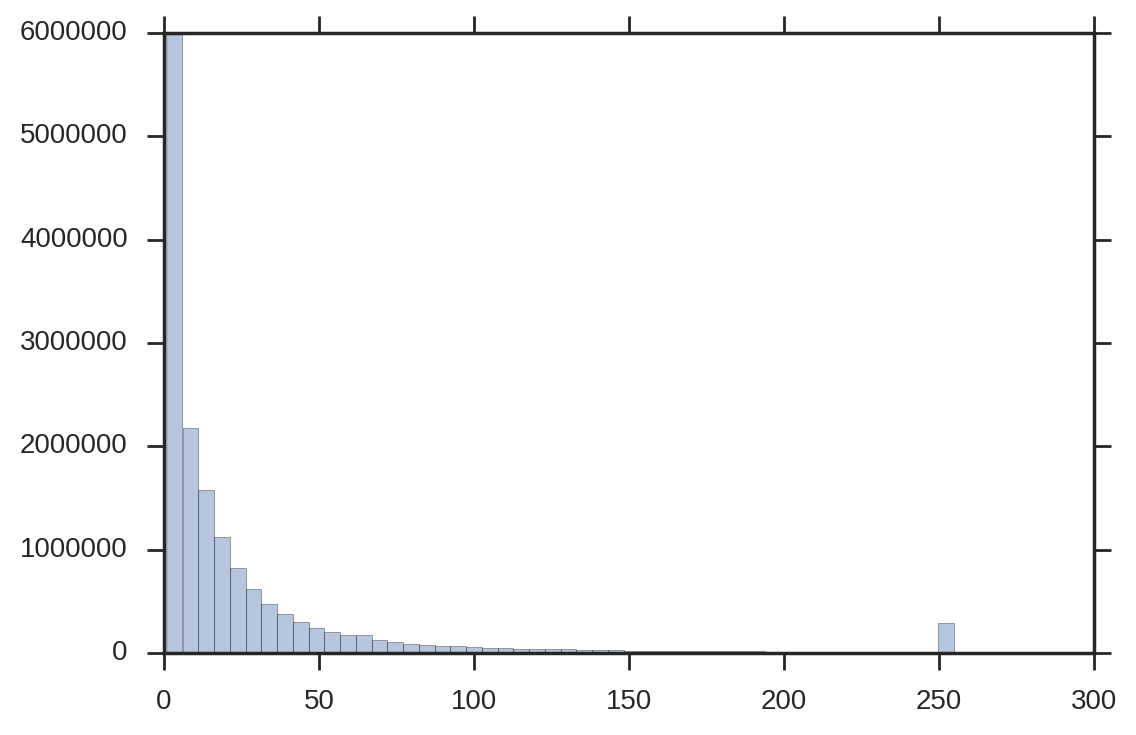

In [356]:
sns.distplot(lump_counts, kde=False)

In [357]:
lump_degrees = []
for tag in lump:
    lump_degrees.append(trav.degree(Kmer.create(tag, sp.graph.ksize())))

In [358]:
lump_kmers = pd.DataFrame({'tag': list(lump), 
                           'kmer': [reverse_hash(tag, sp.graph.ksize()) for tag in lump],
                           'count': lump_counts,
                           'degree': lump_degrees})

In [359]:
lump_kmers['n_A'] = lump_kmers.kmer.str.count('A')
lump_kmers['n_C'] = lump_kmers.kmer.str.count('C')
lump_kmers['n_G'] = lump_kmers.kmer.str.count('G')
lump_kmers['n_T'] = lump_kmers.kmer.str.count('T')

In [360]:
lump_kmers['GC'] = (lump_kmers['n_C'] + lump_kmers['n_G']) / sp.graph.ksize()

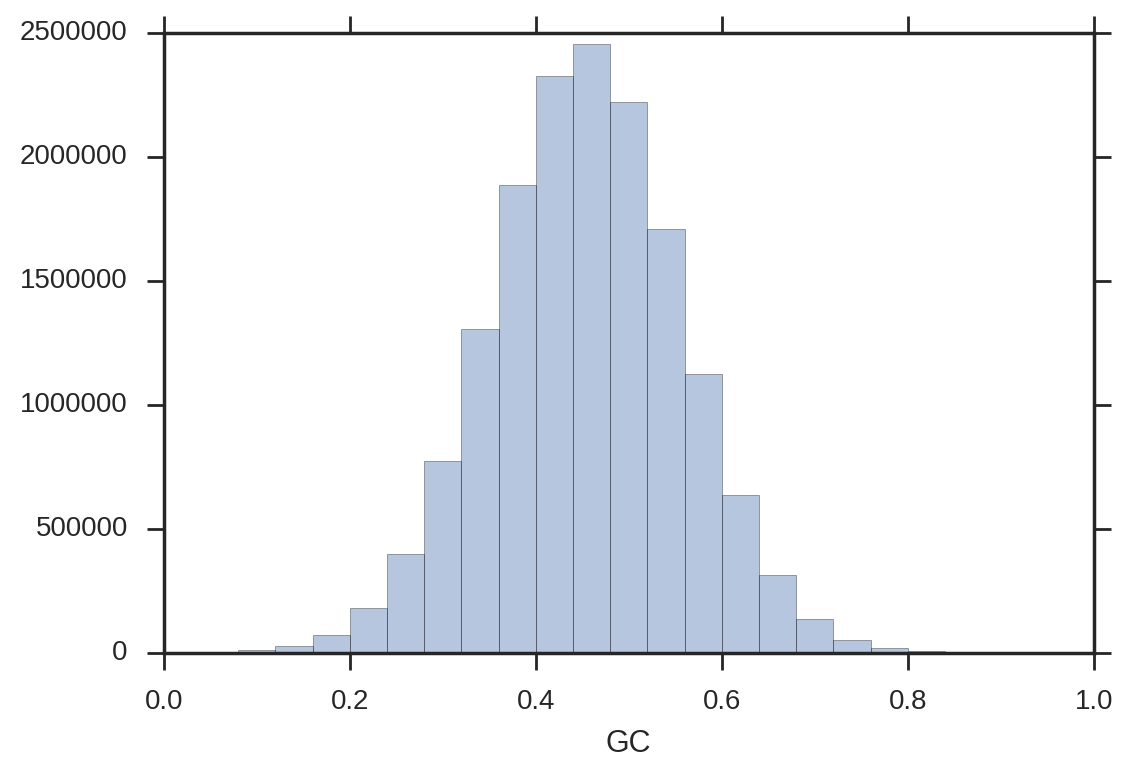

In [361]:
sns.distplot(lump_kmers.GC, kde=False, bins=sp.graph.ksize())

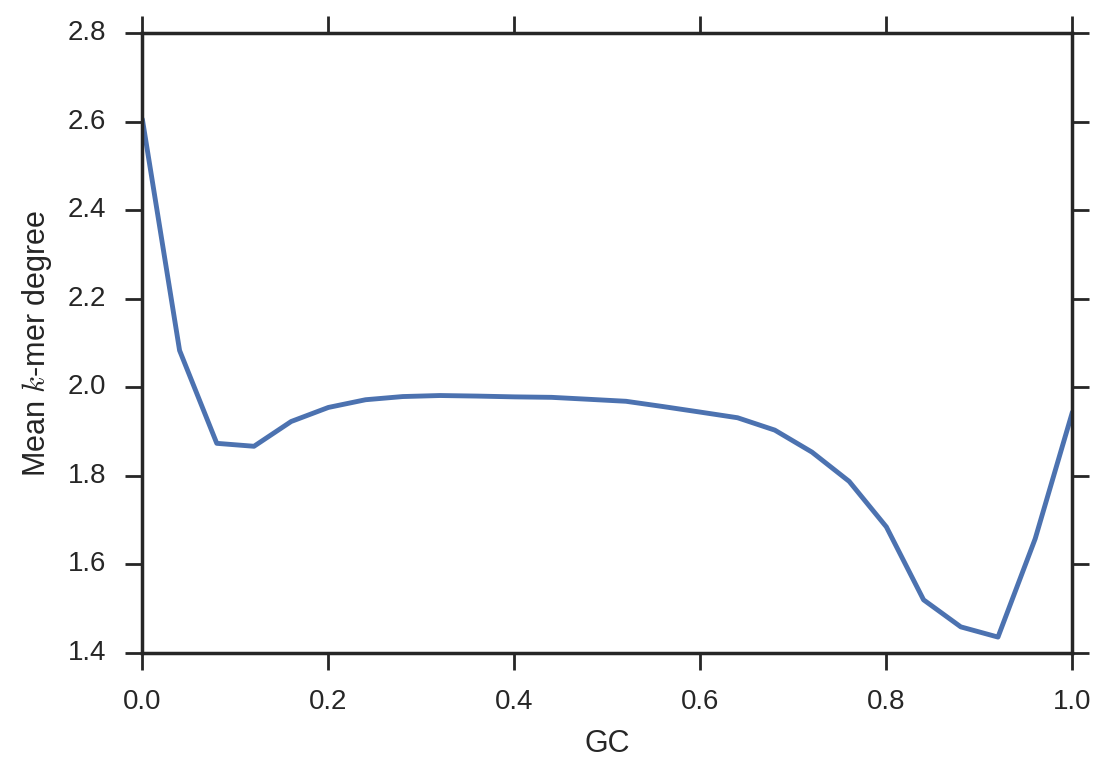

In [362]:
lump_kmers.groupby('GC').mean()['degree'].plot()
ylabel('Mean $k$-mer degree')

In [363]:
lump_kmers = pd.melt(lump_kmers, 
                     id_vars=['kmer', 'tag', 'count', 'degree', 'GC'], 
                     value_vars=['n_A', 'n_C', 'n_G', 'n_T'], 
                     value_name='nucl_count')

In [364]:
lump_kmers.head(10)

,kmer,tag,count,degree,GC,variable,nucl_count
0,AAAAAAAAAAAAAAAAAAAAAAAAA,0,255,8,0.00,n_A,25
1,AAAAAAAAAAAAAAAAAAAAAAAAT,1,200,8,0.00,n_A,24
2,AAAAAAAAAAAAAAAAAAAAAAAAC,2,255,8,0.04,n_A,24
3,AAAAAAAAAAAAAAAAAAAAAAAAG,3,226,8,0.04,n_A,24
4,AAAAAAAAAAAAAAAAAAAAAAATA,4,106,8,0.00,n_A,24
5,AAAAAAAAAAAAAAAAAAAAAAATT,5,71,8,0.00,n_A,23
6,AAAAAAAAAAAAAAAAAAAAAAATG,7,3,8,0.04,n_A,23
7,AAAAAAAAAAAAAAAAAAAAAAACA,8,38,8,0.04,n_A,24
8,AAAAAAAAAAAAAAAAAAAAAAACT,9,226,8,0.04,n_A,23
9,AAAAAAAAAAAAAAAAAAAAAAACC,10,22,8,0.08,n_A,23


In [365]:
lump_nucl_content = lump_kmers.groupby(['variable', 'nucl_count']).mean()[['count', 'degree']]

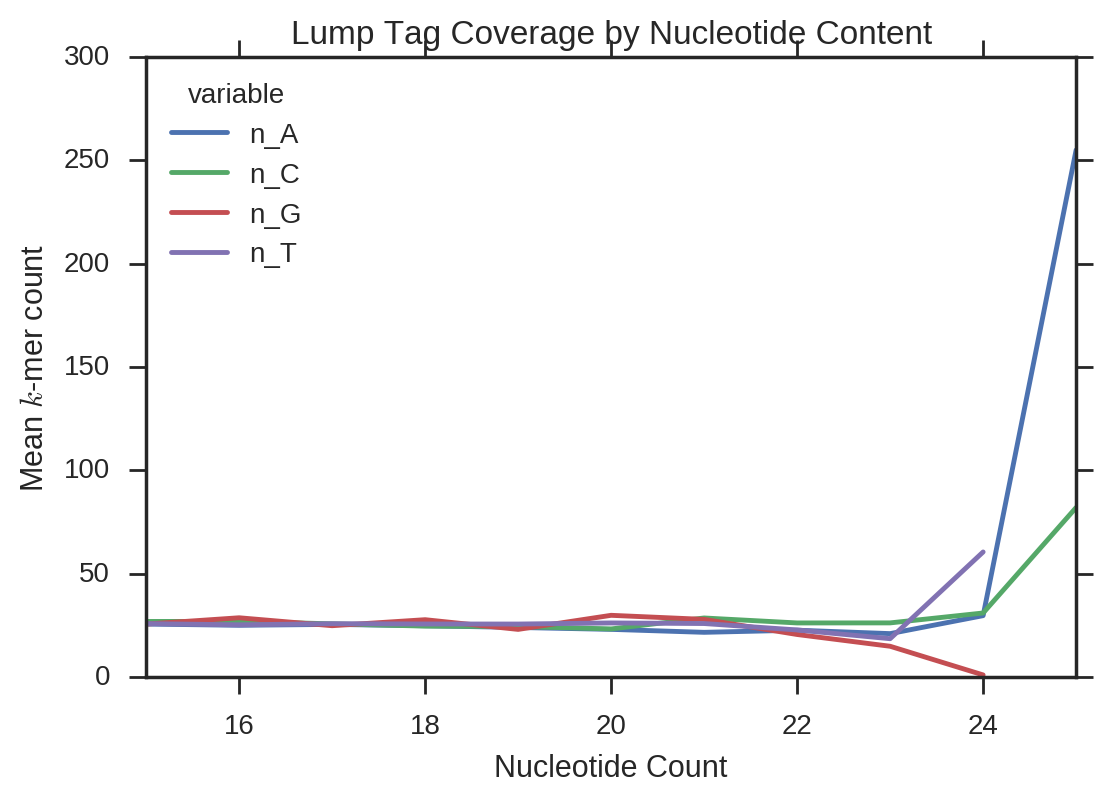

In [366]:
lump_nucl_content.unstack(level=0).plot(y='count', xlim=[15,25])
ylabel('Mean $k$-mer count')
xlabel('Nucleotide Count')
title('Lump Tag Coverage by Nucleotide Content')
savefig('lump_tag_cov_by_nucl.png', dpi=600)

In [367]:
FileLink('images/lump_tag_cov_by_nucl.png')

/work/streaming-assembly/notebooks/images/lump_tag_cov_by_nucl.png

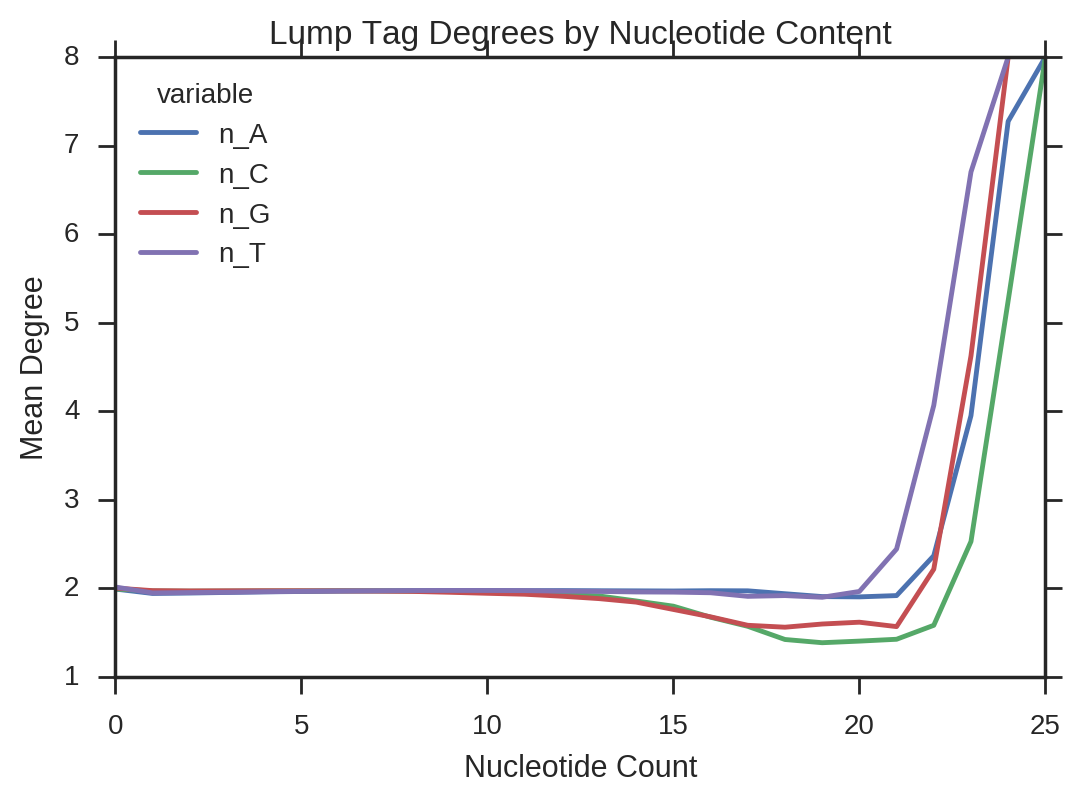

In [368]:
lump_nucl_content.unstack(level=0).plot(y='degree')
ylabel('Mean Degree')
xlabel('Nucleotide Count')
title('Lump Tag Degrees by Nucleotide Content')
savefig('images/lump_tag_deg_by_nucl.png', dpi=600)

In [369]:
FileLink('lump_tag_deg_by_nucl.png')

/work/streaming-assembly/notebooks/lump_tag_deg_by_nucl.png

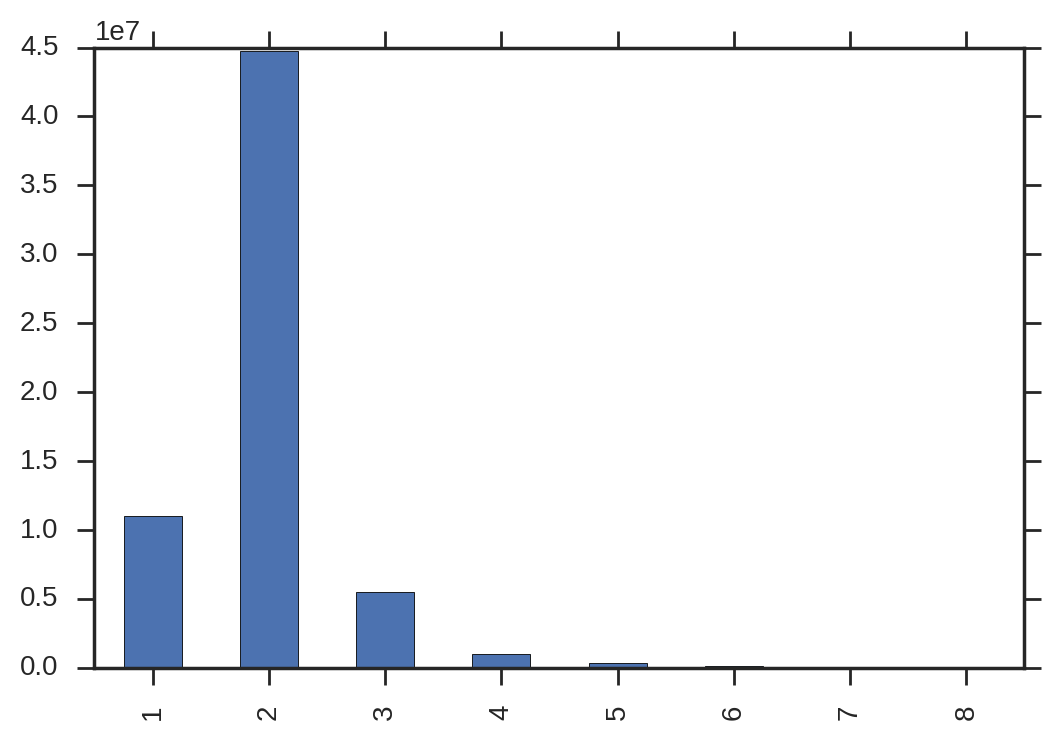

In [370]:
lump_kmers.degree.value_counts(sort=False).plot(kind='bar')

In [301]:
def extract_local_compact_dbg(start, graph, max_breadth=None, verbose=True):

    from khmer._oxli.assembly import CompactingAssembler
    import networkx as nx
    from collections import deque
    from khmer import reverse_complement
    
    def kmer_str(kmer):
        return '{0}/{1}'.format(kmer.kmer, reverse_complement(kmer.kmer))

    K = graph.ksize()
    G = nx.Graph()
    q = deque()
    breadth = deque()
    seen = set()
    
    kmers = set()
    def add_kmers(path):
        for i in range(0, len(path)-K+1):
            kmers.add(hash(Kmer(path[i:i+K])))

    trav = Traverser(graph)
    asm = CompactingAssembler(graph)
    path = asm.assemble(Kmer(start))
    
    def add(src, dst, path):
        path_cov, _, _ = graph.get_median_count(path)
        if verbose:
            add_kmers(path)
            add_kmers(src.kmer)
            add_kmers(dst.kmer)
        G.add_edge(hash(src), hash(dst), path=path, Weight=len(path)-K+1, coverage=path_cov)
        G.add_node(hash(src), kmer=kmer_str(src), coverage=graph.get(src.kmer))
        G.add_node(hash(dst), kmer=kmer_str(dst), coverage=graph.get(dst.kmer))

    src = Kmer(path[:K])
    dst = Kmer(path[-K:])
    if hash(src) != hash(dst):
        add(src, dst, path)
        q.append(src)
        breadth.append(0)
    q.append(dst)
    breadth.append(0)

    n = 0
    while(len(q) > 0):
        src = q.popleft()
        cur_breadth = breadth.popleft()

        if n % 1000 == 0:
            if verbose:
                print(n, 'iterations, ', len(G.nodes()), 'nodes,', len(q), 'on queue, breadth at', cur_breadth)
            else:
                if n % 50000 == 0:
                    print(n, 'iterations, ', len(G.nodes()), 'nodes,', len(q), 'on queue, breadth at', cur_breadth)
        if max_breadth is not None and cur_breadth > max_breadth:
            if verbose:
                print('max breadth reached at', len(G.nodes()), 'nodes')
            break
        n += 1

        for neighbor in trav.neighbors(src):
            if hash(neighbor) in seen:
                continue
            if hash(neighbor) == hash(src):
                continue
            seen.add(hash(neighbor))

            path = asm.assemble(neighbor)
            #print(neighbor, path, len(path))
            if len(path) == K:
                add(src, neighbor, path)
                seen.add(hash(src))
                q.append(neighbor)
                breadth.append(cur_breadth + 1)
                continue

            left = Kmer(path[:K])
            right = Kmer(path[-K:])
            if hash(neighbor) == hash(left):
                dst = right
                seen.add(hash(Kmer(path[-K-1:-1])))
            elif hash(src) == hash(left):
                dst = right
            elif hash(neighbor) == hash(right):
                dst = left
                seen.add(hash(Kmer(path[1:K+1])))
            elif hash(src) == hash(right):
                dst = left
            else:
                print(src, trav.degree(src), '\n', 
                      neighbor, reverse_complement(neighbor.kmer), trav.degree(neighbor), '\n',
                      left, right, path, seen)
                raise RuntimeError()

            add(src, dst, path)
            q.append(dst)
            breadth.append(cur_breadth + 1)
    # normalize edge weights
    max_weight = max([G.get_edge_data(*e)['Weight'] for e in G.edges()])
    for e in G.edges():
        data = G.get_edge_data(*e)
        data['Weight'] = float(data['Weight']) / max_weight

    if verbose:
        print(n, 'iterations, ', len(G.nodes()), 'nodes,', len(q), 'on queue, breadth at', 
              cur_breadth, len(kmers), 'k-mers')
    return G

In [12]:
max(list(nx.degree(G).values()))

8

In [96]:
G_lump.get_edge_data(0, 281474976710656)['Weight'] = 4

In [103]:
[G_lump.get_edge_data(*e)['Weight'] for e in G_lump.edges()]

[0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.007874015748031496,
 0.00787401

In [139]:
G_lump = extract_local_compact_dbg('A' * 25, sp.graph, max_breadth=50)

0 iterations,  0 nodes, 0 on queue, breadth at 0
1000 iterations,  2075 nodes, 1237 on queue, breadth at 5
2000 iterations,  3317 nodes, 1766 on queue, breadth at 6
3000 iterations,  4479 nodes, 2272 on queue, breadth at 7
4000 iterations,  5519 nodes, 2659 on queue, breadth at 7
5000 iterations,  6410 nodes, 2913 on queue, breadth at 8
6000 iterations,  7315 nodes, 3272 on queue, breadth at 8
7000 iterations,  8196 nodes, 3578 on queue, breadth at 8
8000 iterations,  9047 nodes, 3817 on queue, breadth at 9
9000 iterations,  9863 nodes, 4049 on queue, breadth at 9
10000 iterations,  10684 nodes, 4255 on queue, breadth at 9
11000 iterations,  11484 nodes, 4474 on queue, breadth at 9
12000 iterations,  12358 nodes, 4763 on queue, breadth at 10
13000 iterations,  13120 nodes, 4960 on queue, breadth at 10
14000 iterations,  13921 nodes, 5152 on queue, breadth at 10
15000 iterations,  14744 nodes, 5375 on queue, breadth at 10
16000 iterations,  15553 nodes, 5626 on queue, breadth at 10
1700

In [280]:
G_lump_full = extract_local_compact_dbg('A' * 25, sp.graph, verbose=False)

0 iterations,  0 nodes, 0 on queue, breadth at 0
50000 iterations,  42809 nodes, 12641 on queue, breadth at 15
100000 iterations,  82114 nodes, 22488 on queue, breadth at 18
150000 iterations,  118366 nodes, 29867 on queue, breadth at 20
200000 iterations,  152386 nodes, 35278 on queue, breadth at 22
250000 iterations,  184722 nodes, 38541 on queue, breadth at 23
300000 iterations,  216946 nodes, 41738 on queue, breadth at 24
350000 iterations,  248707 nodes, 44428 on queue, breadth at 26
400000 iterations,  280354 nodes, 47086 on queue, breadth at 27
450000 iterations,  311547 nodes, 49139 on queue, breadth at 28
500000 iterations,  342501 nodes, 50700 on queue, breadth at 29
550000 iterations,  372922 nodes, 51733 on queue, breadth at 30
600000 iterations,  403108 nodes, 52311 on queue, breadth at 31
650000 iterations,  433618 nodes, 53050 on queue, breadth at 32
700000 iterations,  463984 nodes, 53456 on queue, breadth at 33
750000 iterations,  494564 nodes, 54359 on queue, breadth 

In [104]:
nx.write_gml(G_lump, 'component-subsample-{0}.gml'.format(lump.component_id), )

In [281]:
lump_centrality = pd.DataFrame({'centrality':nx.centrality.eigenvector_centrality(G_lump_full, weight='coverage')})

In [128]:
print('\n'.join(['>{0}\n{1}'.format(n, G_lump_full.node[n]['kmer'][:25]) for n,d in nx.degree(G_lump_full).items() if d == 9]))

>499604117652391
CAGGCTTTGACCAAGTCTGAGATCA
>460032190954739
TCCACTCTTCTTGTTAGCGGAGGAG
>368241324220894
GCACATGAGTAAACACAGGCGCTAA
>53808337628903
AAGAAGGAAAGCCGTCTCCGCGCTG
>697733847628470
GACGGGCGGTGTGTACAAAGGGCAG
>289730208293299
CTCGATGAAAGTGTATGTTGCATTA
>51754744265853
ACCATCCGAAGTCAATGTATCCGTT
>752856896119578
CCCGACGCAACTGGTGAACAGATCC
>216924397683620
AGATTTACCCCTTCCCCGAAGCCTA
>450553535362826
GGTTCACAACGACGGGGATCAGAGA
>183088559218282
GGGAGCACTGTGTTGGTATGGAGGT
>693087573631078
GAGATTGCCCAGGATTTCAAGACAG
>123542523473980
TCCTTTCCAGCTTCCATCAATTCAT
>529432943248808
TGCATCATAAGTCCAAGGATTCCCA
>108787783533728
TTGGTATGATCTATGTATCCGTGAT
>623860080632718
CAGTGTCTTCGGCTGGCGCAGCAGC
>658070847750927
CTTTCCAAGAAGGATGCAAAGAAGG
>11403879321502
GCAGCCTTACGTTCGTCCAAGGTTT
>411901806036348
TTGTCCTGGTTGAGTTAGATTTGGA
>489266180559647
TCGGAGGGAACCAGCTACTAGATGG
>295157793043504
TAAGATGATGATGTCCAAGTAAGAA
>148469477140894
GCAGAGGCATCAGCCTTGTTCATGT


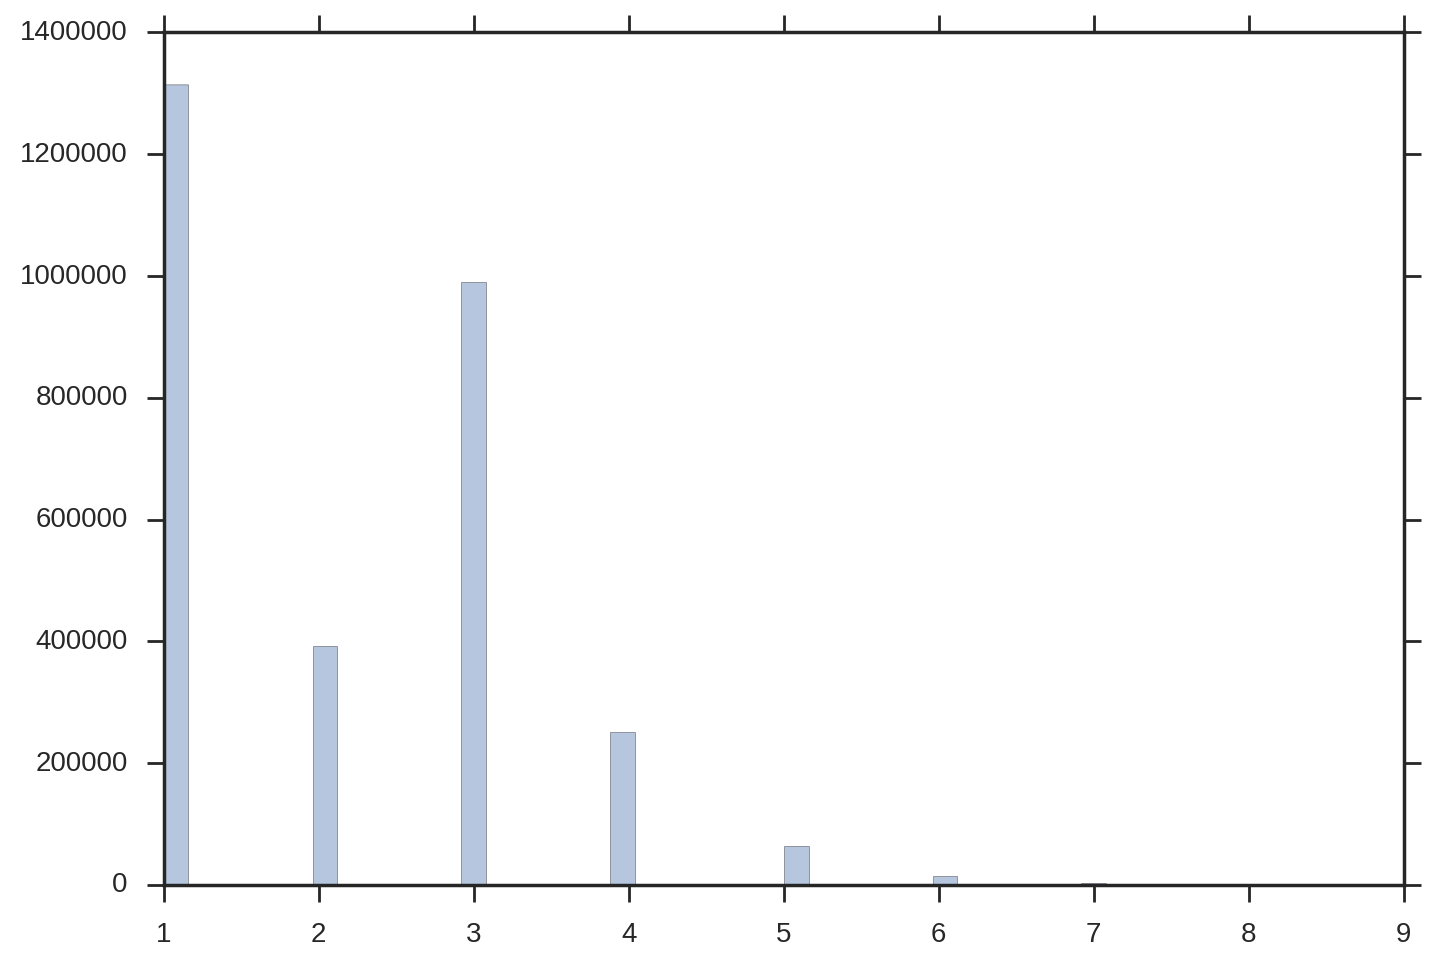

In [112]:
sns.distplot(list(nx.degree(G_lump_full).values()), kde=False)

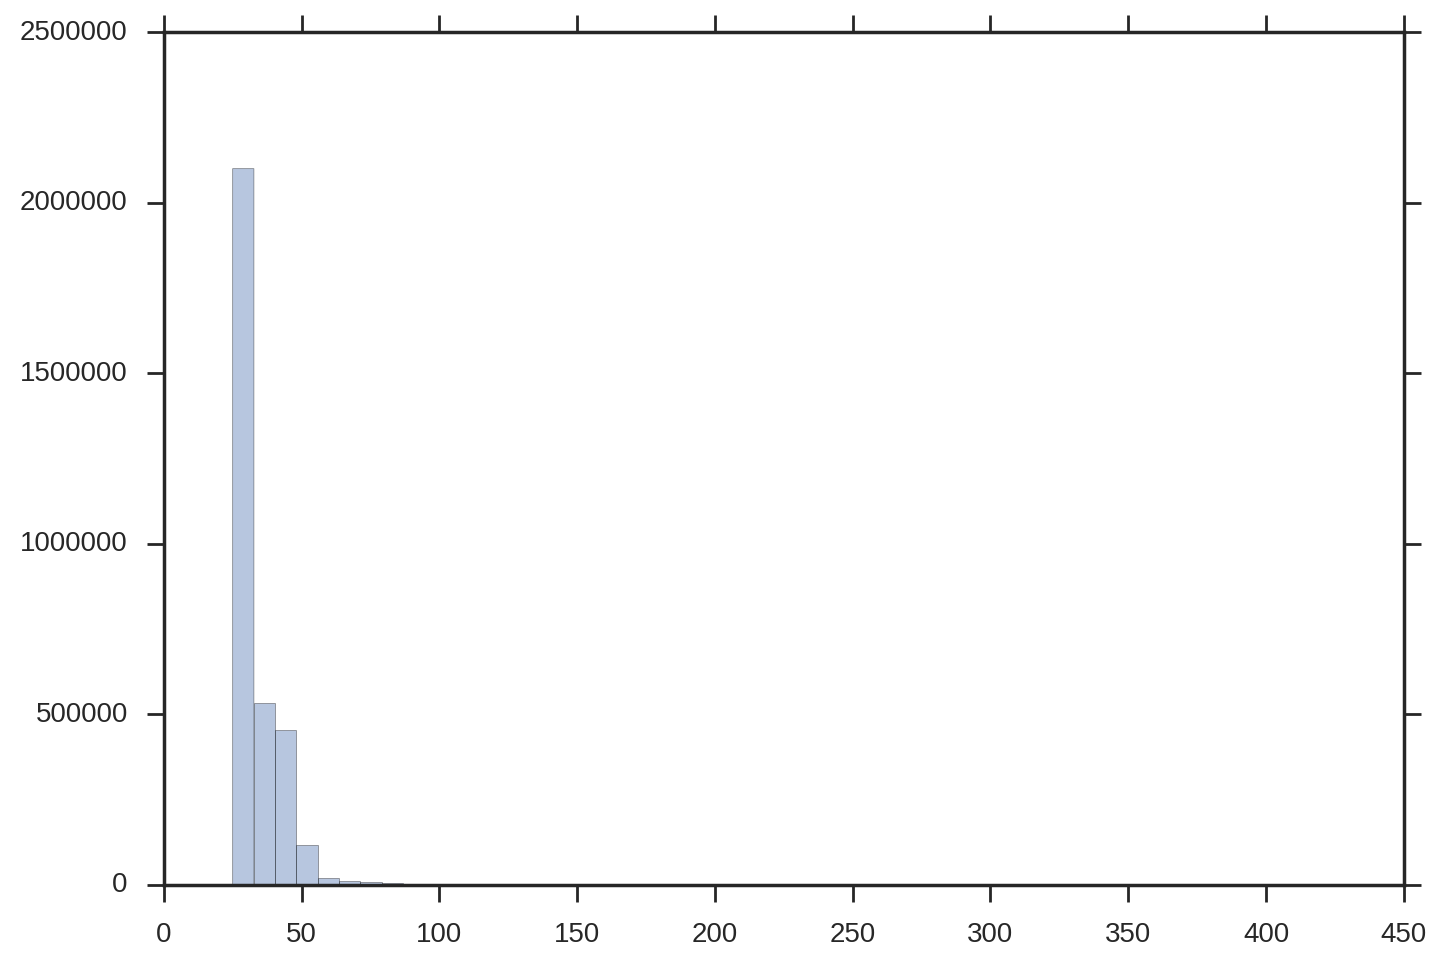

In [111]:
sns.distplot([len(G_lump_full.get_edge_data(*e)['path']) for e in G_lump_full.edges()], kde=False)

In [9]:
sp.graph.calc_connected_graph_size('A' * 25)

25294103

In [89]:
G_rep = extract_local_compact_dbg(reverse_hash(list(rep_comp)[0], 25), sp.graph)

0 iterations,  2 nodes, 1 on queue, breadth at 0
474 iterations,  243 nodes, 0 on queue, breadth at 97 3849 k-mers


In [49]:
sp.graph.calc_connected_graph_size(reverse_hash(list(rep_comp)[0], 25))

3849

In [84]:
[(G_rep.node[i], i, G_rep.degree(i), sp.graph.kmer_degree(reverse_hash(i, 25))) for i in G_rep.nodes() if sp.graph.kmer_degree(reverse_hash(i, 25)) != G_rep.degree(i)]

[({'coverage': 13,
   'kmer': 'AAGAATTAGATGTAAAAAGCCATGA/TCATGGCTTTTTACATCTAATTCTT'},
  53133526972956,
  4,
  3),
 ({'coverage': 15,
   'kmer': 'TTTCTTTTAGGTGTCTAAGTAACTG/CAGTTACTTAGACACCTAAAAGAAA'},
  379696439374887,
  4,
  3),
 ({'coverage': 4,
   'kmer': 'ACACAGAATATAAAACTAGAATAGC/GCTATTCTAGTTTTATATTCTGTGT'},
  150362779103310,
  5,
  4),
 ({'coverage': 1,
   'kmer': 'GCCGCCTTTCTGTAGTATTGAATTT/AAATTCAATACTACAGAAAGGCGGC'},
  6052222078910,
  2,
  3),
 ({'coverage': 9,
   'kmer': 'CGCTACGTGAAAGAGAGTATGGGAT/ATCCCATACTCTCTTTCACGTAGCG'},
  116627258879291,
  2,
  3),
 ({'coverage': 6,
   'kmer': 'GATGGAGCGCTCCAAGGCGCAAGAG/CTCTTGCGCCTTGGAGCGCTCCATC'},
  675025376962182,
  4,
  3),
 ({'coverage': 7,
   'kmer': 'AAAGGCGGCTGTCCGAAGGTATCAT/ATGATACCTTCGGACAGCCGCCTTT'},
  17310709511265,
  2,
  3),
 ({'coverage': 1,
   'kmer': 'GAGAGGATGATAGATTTATTGAATG/CATTCAATAAATCTATCATCCTCTC'},
  587156494359142,
  2,
  3),
 ({'coverage': 4,
   'kmer': 'CCGAGAACATGAAATATGAATGATT/AATCATTCATATTTCATGTTCTCGG'

In [43]:
nx.write_gml(G_rep, 'component-{0}.gml'.format(rep_comp.component_id), )

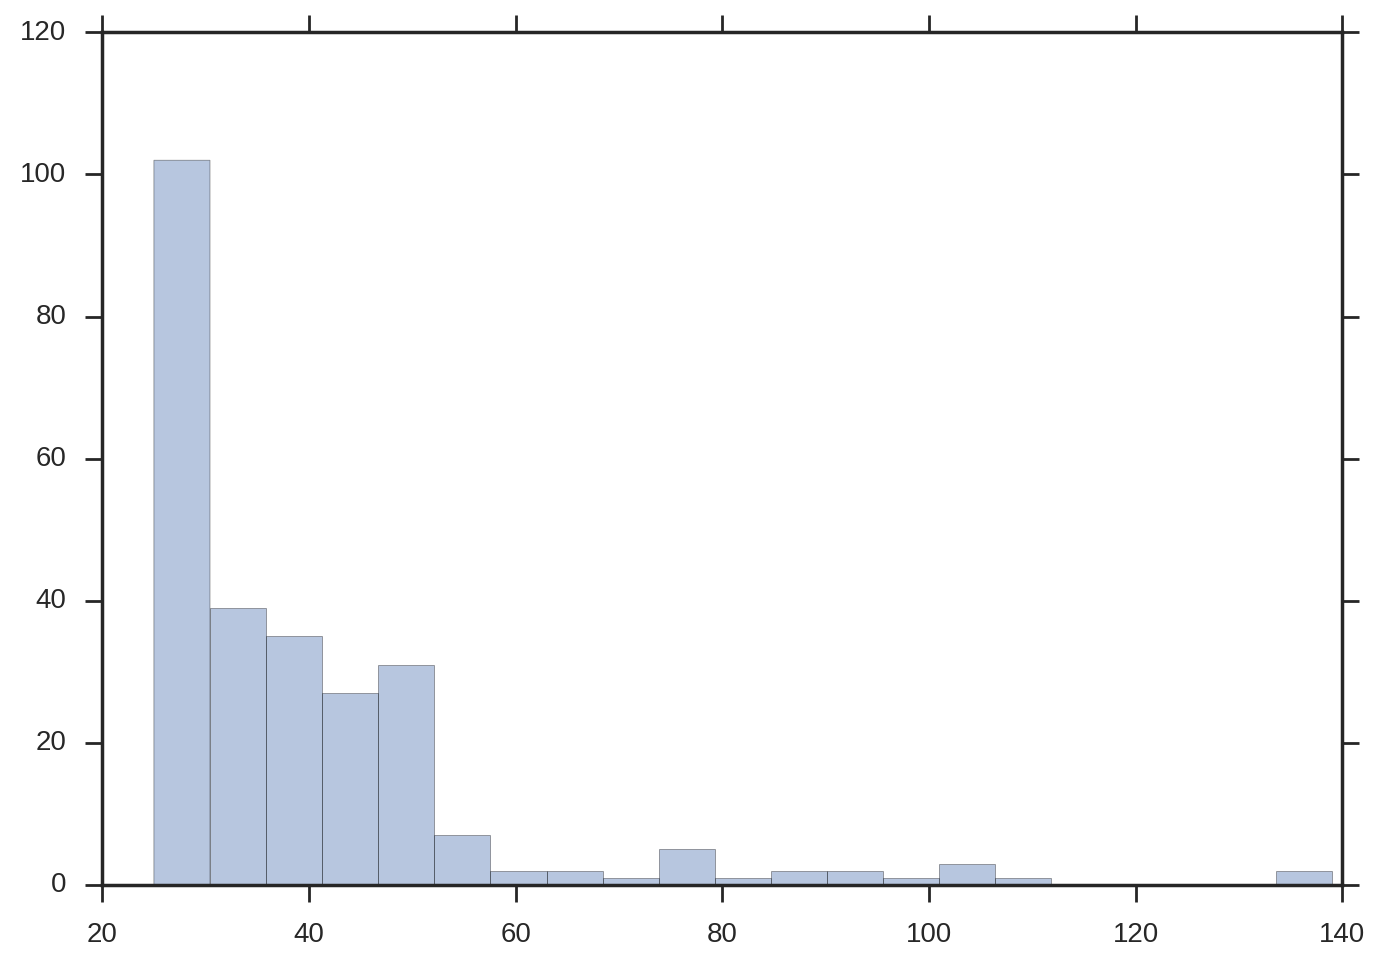

In [28]:
sns.distplot([len(G_rep.get_edge_data(*e)['path']) for e in G_rep.edges()], kde=False)

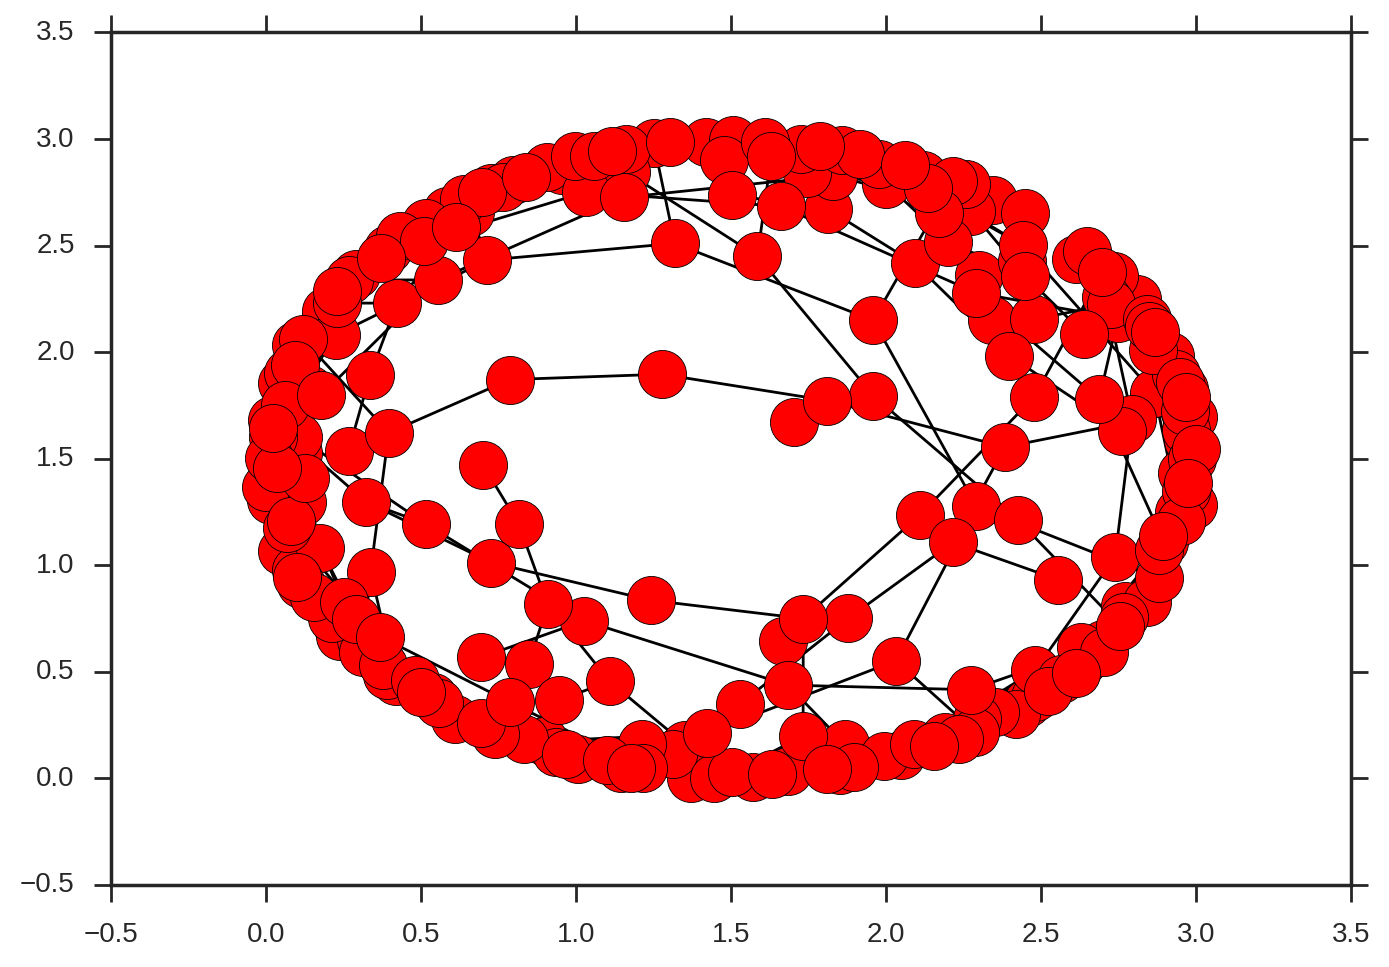

In [29]:
lyt = nx.layout.fruchterman_reingold_layout(G_rep, scale=3.0)
nx.draw_networkx_edges(G_rep, lyt)
nx.draw_networkx_nodes(G_rep, lyt)

In [ ]:
%%cython

In [299]:
%%cython

from khmer._oxli.streaming import SplitPairedReader, FastxParser, Sequence
from khmer._oxli.partitioning import StreamingPartitioner
from khmer import reverse_hash

def kmers(sequence, K, which=[0,1,2,-27,-26,-25]):
    if which is None:
        which = range(0,len(sequence)-K+1)
    for i in which:
        yield sequence[i:i+K]

def read_degrees_by_position(left, right, part, limit=1000000):
    
    reader = SplitPairedReader(FastxParser(left), FastxParser(right))
    K = part.graph.ksize()

    data = {}
    for n, paired, first, second in reader:
        if n % 50000 == 0:
            print(n, '...', sep='')
        if limit and n > limit:
            break
        base = first.name
        fname = base + '.L'
        rname = base + '.R'
        data[fname] = []
        data[rname] = []
        for kmer in kmers(first.sequence, K):
            data[fname].append(part.graph.kmer_degree(kmer))
        for kmer in kmers(second.sequence, K):
            data[rname].append(part.graph.kmer_degree(kmer))
    
    return data

def tag_hexamer_decomposition(comp, K=25):
    
    decomp = {}
    for tag in comp:
        decomp[tag] = [hexamer for hexamer in kmers(reverse_hash(tag, K), 6, which=None)]

    return decomp

In [13]:
read_degrees = read_degrees_by_position('/store/biodb/MMETSP/data/Asterionellopsis_glacialis/SRR1300451/SRR1300451_1.fastq',
                                        '/store/biodb/MMETSP/data/Asterionellopsis_glacialis/SRR1300451/SRR1300451_2.fastq',
                                        sp)

0...
50000...
100000...
150000...
200000...
250000...
300000...
350000...
400000...
450000...
500000...
550000...
600000...
650000...
700000...
750000...
800000...
850000...
900000...
950000...
1000000...


In [14]:
read_degrees_df = pd.DataFrame(read_degrees)

In [28]:
read_degrees_melted = pd.melt(read_degrees_df.reset_index(), id_vars=['index'], value_name='degree',
                  value_vars=list(range(6)), var_name='position')

In [32]:
ttest_ind(read_degrees_melted.query('position in [0,1,2]').degree,
          read_degrees_melted.query('position in [3,4,5]').degree)

Ttest_indResult(statistic=11.34514920371045, pvalue=7.8447385924038063e-30)

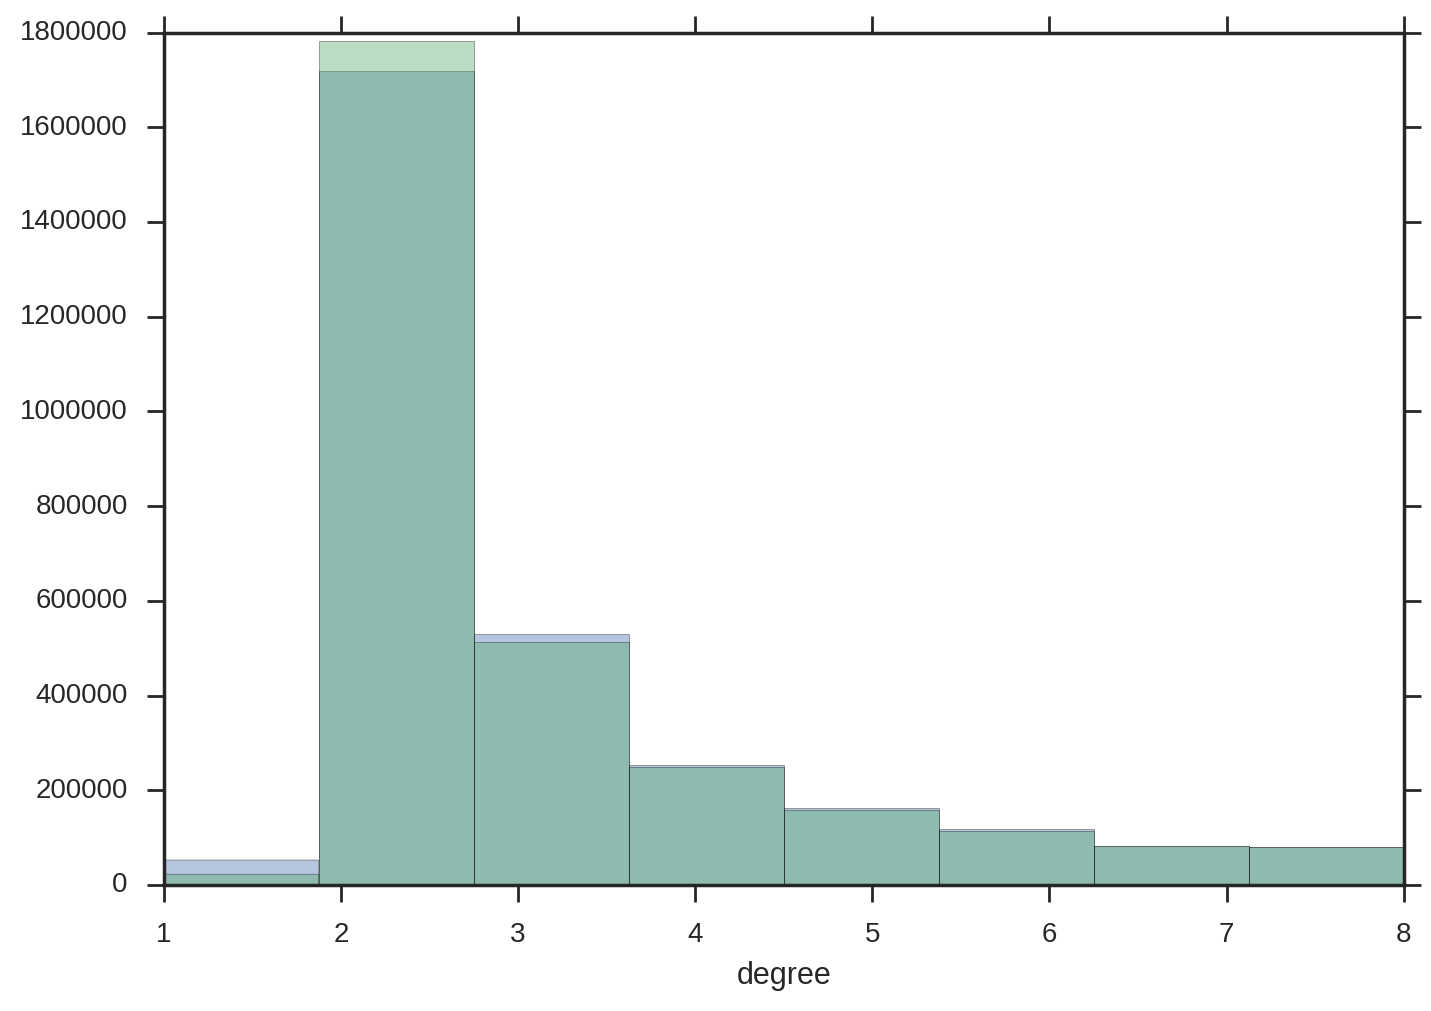

In [36]:
sns.distplot(read_degrees_melted.query('position in [0,1,2]').degree, bins=8, kde=False)
sns.distplot(read_degrees_melted.query('position in [3,4,5]').degree, bins=8, kde=False)

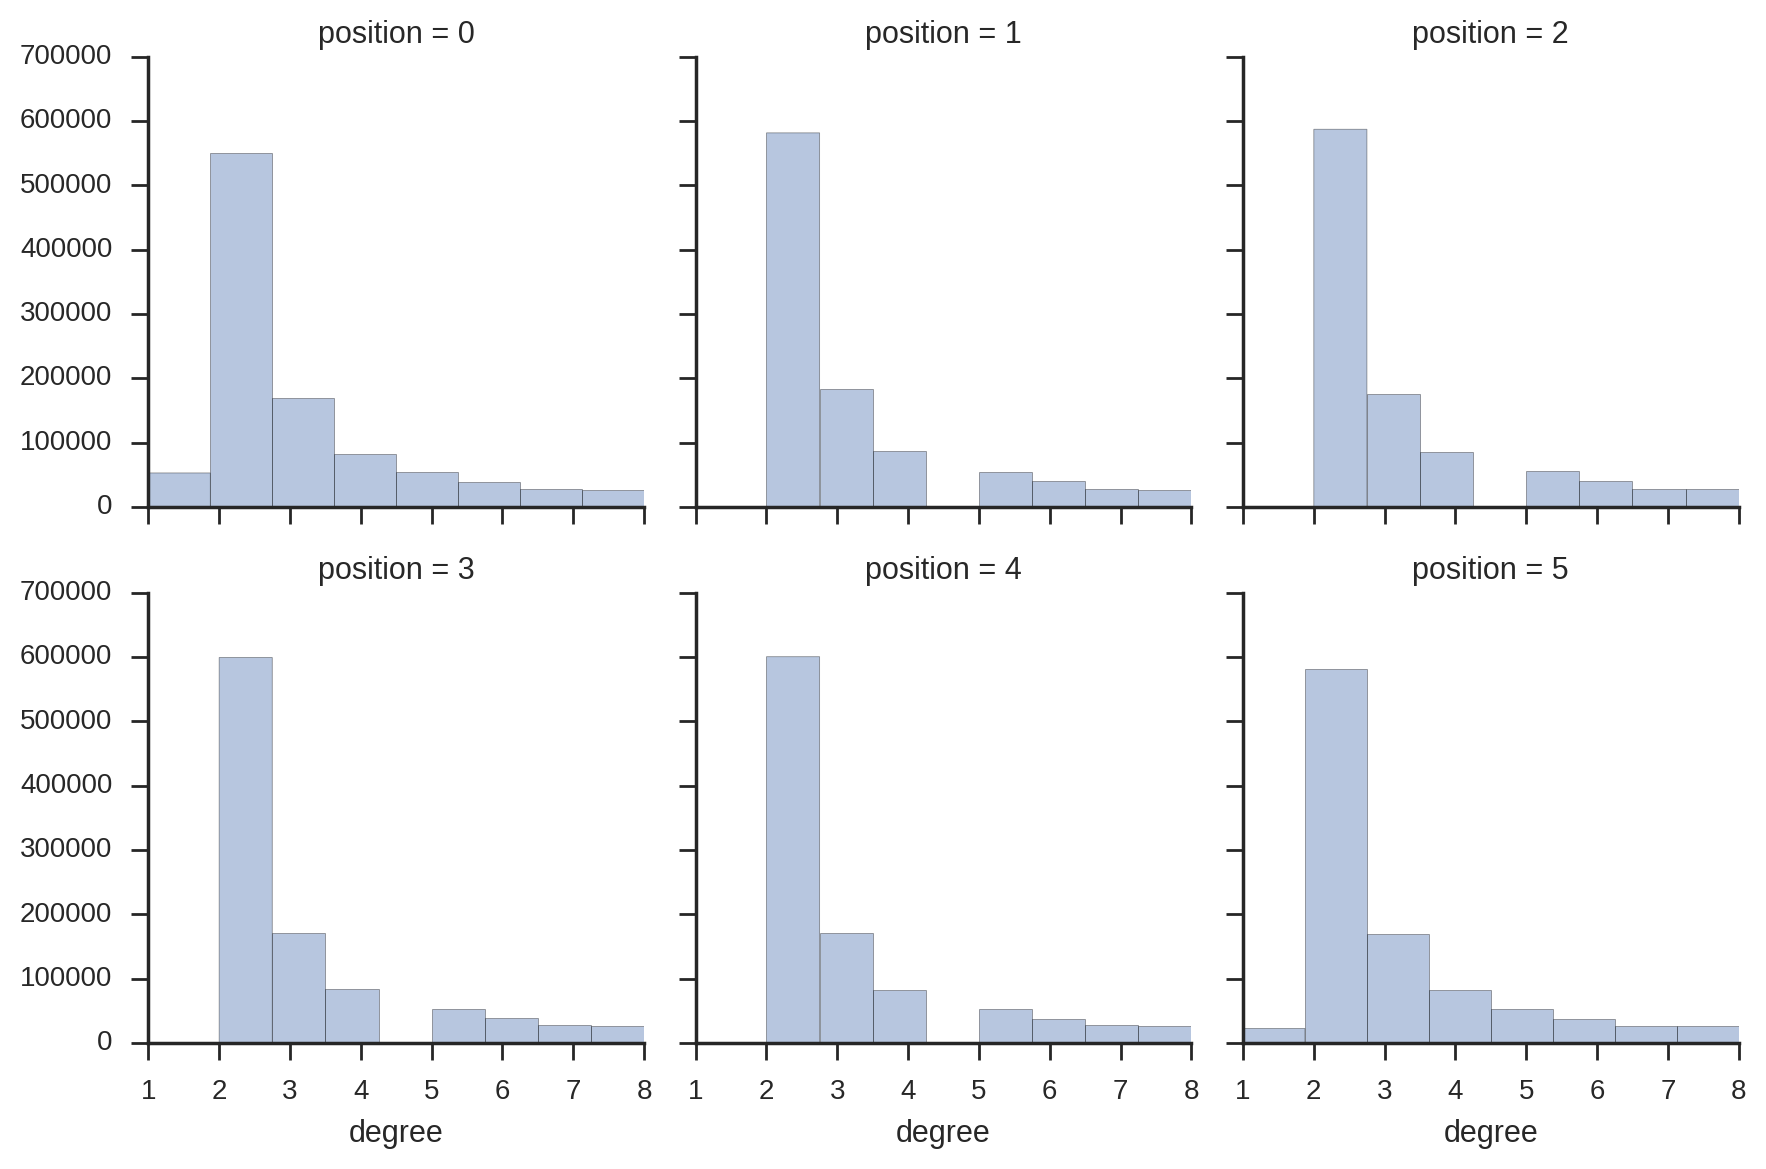

In [35]:
g = sns.FacetGrid(read_degrees_melted, col_wrap=3, col='position')
g.map(sns.distplot, 'degree', bins=8, kde=False)

In [45]:
lump_tags = set(lump)

In [40]:
from khmer import Nodegraph

In [41]:
lump_filter = Nodegraph(25, 1e8, 4)
for tag in lump:
    lump_filter.count(reverse_hash(tag, 25))

In [233]:
 def tag_read_positions(left, right, comp, K=25, limit=1000000):
    
    reader = SplitPairedReader(FastxParser(left), FastxParser(right))
    tags = set(comp)
    
    data = []
    for n, paired, first, second in reader:
        if n % 50000 == 0:
            print(n, '...', sep='')
        if limit and n > limit:
            break
        for i, kmer in enumerate(kmers(first.sequence, K, which=None)):
            tag = hash(Kmer(kmer))
            if tag in tags:
                data.append((tag,i,'L'))
        for i, kmer in enumerate(kmers(second.sequence, K, which=None)):
            tag = hash(Kmer(kmer))
            if tag in tags:
                data.append((tag, i + len(first.sequence), 'R'))
    return data

In [234]:
lump_tag_positions = tag_read_positions('/store/biodb/MMETSP/data/Asterionellopsis_glacialis/SRR1300451/SRR1300451_1.fastq',
                                        '/store/biodb/MMETSP/data/Asterionellopsis_glacialis/SRR1300451/SRR1300451_2.fastq',
                                        lump, limit=500000)

0...
50000...
100000...
150000...
200000...
250000...
300000...
350000...
400000...
450000...
500000...


In [238]:
lump_tag_positions = pd.DataFrame(lump_tag_positions, columns=['tag', 'position', 'pair'])

In [300]:
lump_hexamers = tag_hexamer_decomposition(lump)

In [284]:
lump_centrality.reset_index(inplace=True)
lump_centrality.rename(columns={'index': 'tag'}, inplace=True)

In [285]:
lump_centrality.head()

,tag,centrality
0,0,0.000173
1,1,0.000078
2,2,0.000114
3,3,0.000091
4,4,0.000011


/home/camille/miniconda/envs/dev.py3.khmer.assembly/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


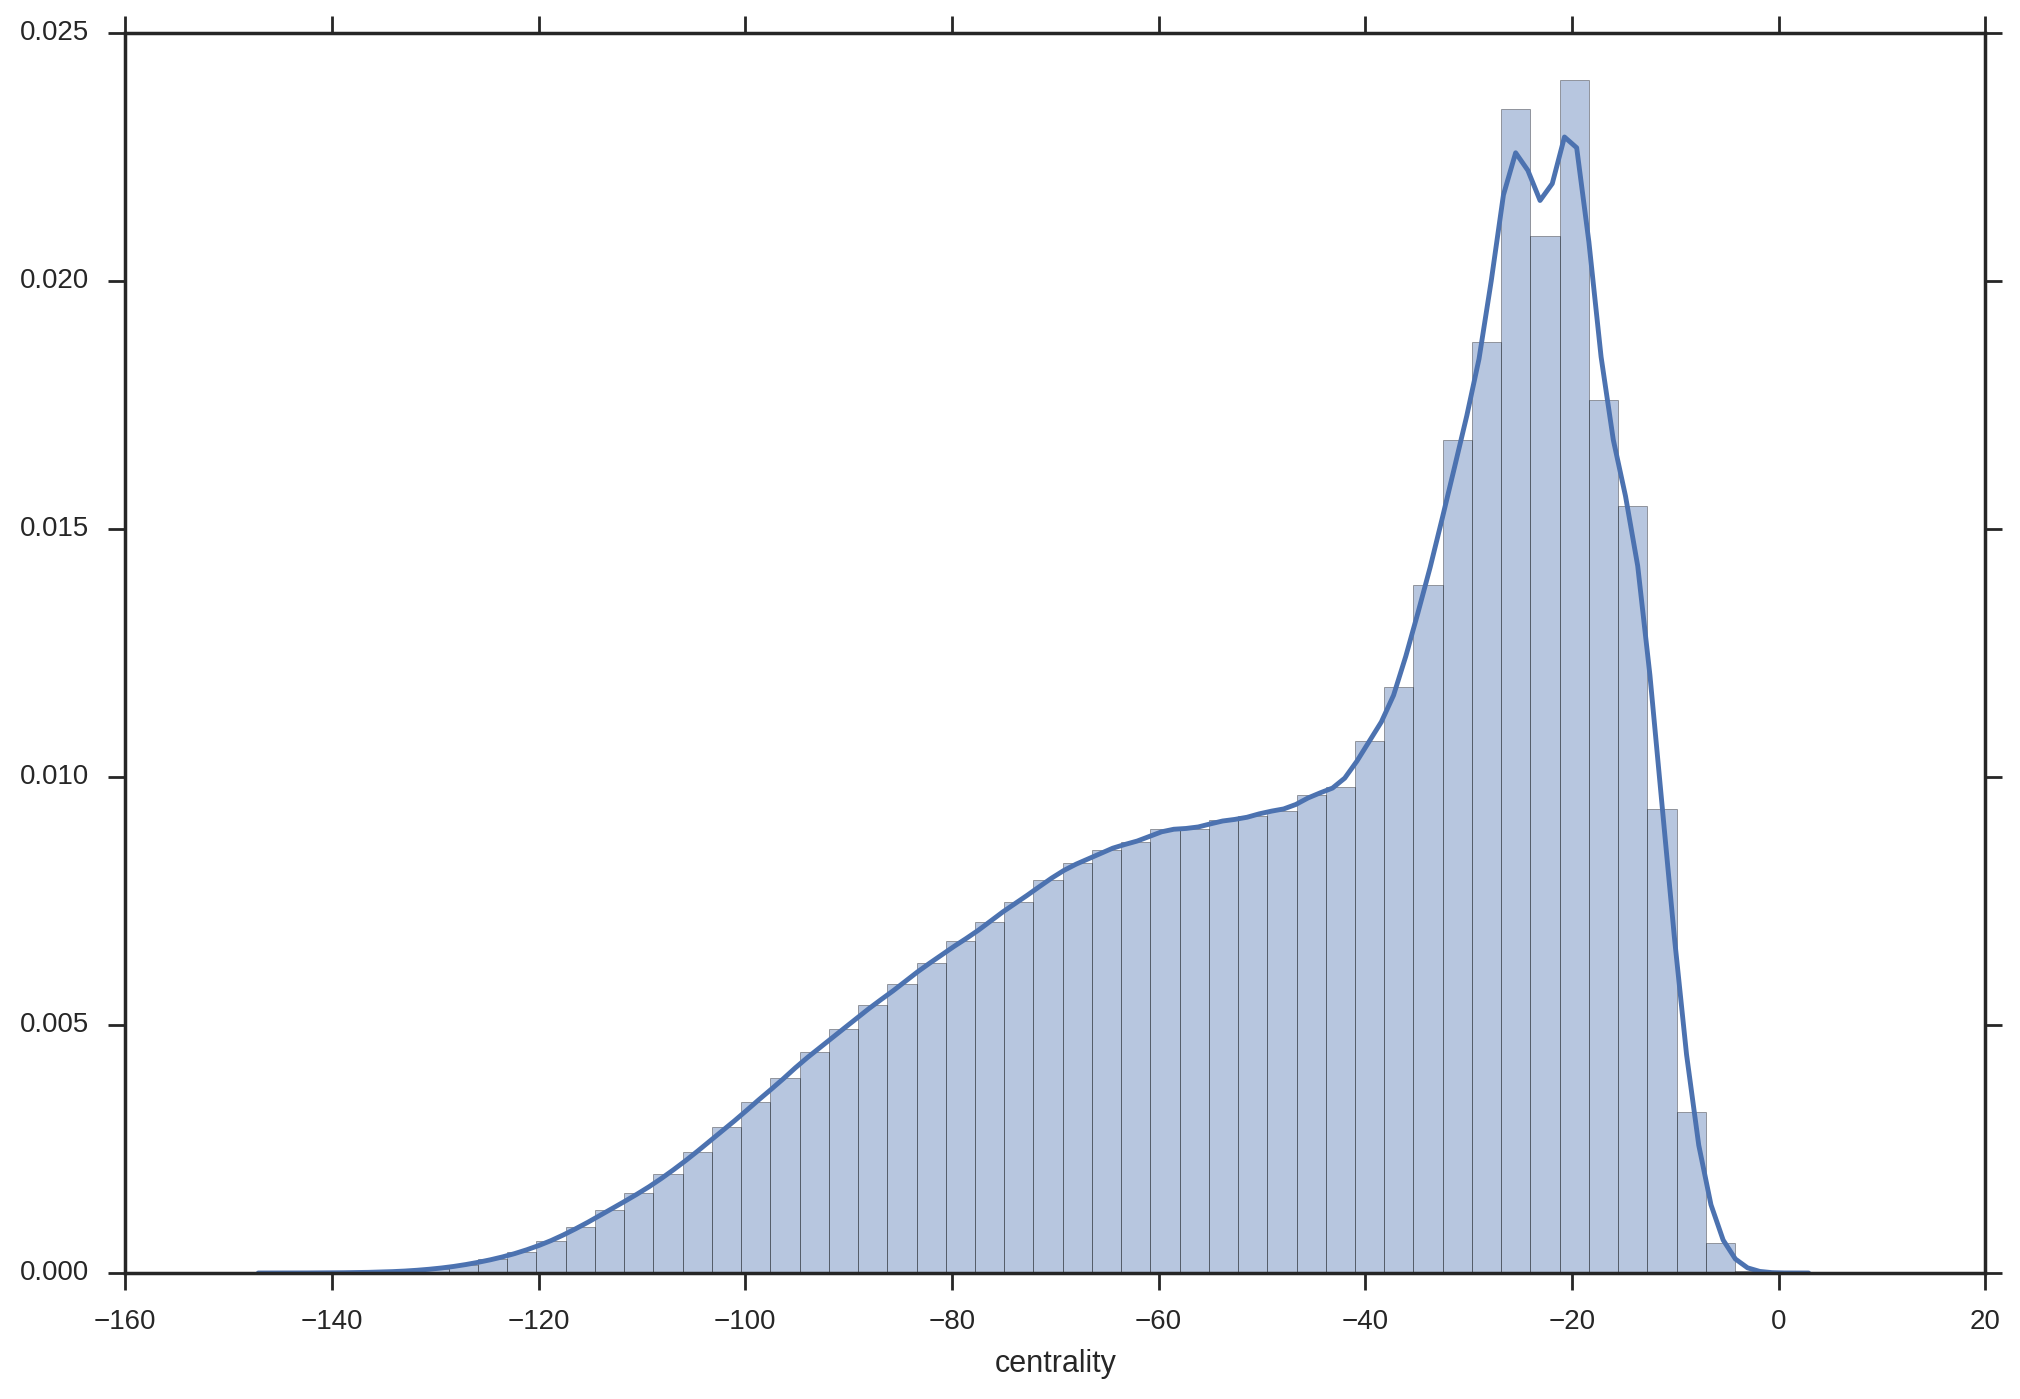

In [282]:
sns.distplot(log(lump_centrality['centrality']))

In [259]:
lump_tag_positions

,tag,position,pair
0,848893025205450,0,L
1,17872380293928,1,L
2,71489521175712,2,L
3,104894234772756,3,L
4,17932431968773,4,L
5,71729727875094,5,L
6,286918911500378,6,L
7,21775739158888,7,L
8,87102956635555,8,L
9,348411826542222,9,L


In [286]:
lump_stats = pd.merge(lump_centrality, lump_tag_positions, on='tag')

In [287]:
lump_stats['centrality'] = np.log(lump_stats['centrality'])

In [288]:
lump_stats['degree'] = lump_stats.tag.apply(lambda tag: sp.graph.kmer_degree(reverse_hash(tag, 25)))

In [303]:
from khmer import reverse_complement

In [304]:
lump_stats['kmer_f'] = lump_stats.tag.apply(lambda tag: reverse_hash(tag, 25))
lump_stats['kmer_r'] = lump_stats.kmer_f.apply(lambda kmer_f: reverse_complement(kmer_f))

In [337]:
freqs = {}
for i in range(100):
    freqs[i] = {'A': 0, 'C': 0, 'G': 0, 'T': 0}

In [338]:
def base_pos_count(row):
    for i, (b1,b2) in enumerate(zip(row.kmer_f, row.kmer_r)):
        freqs[i+row.position][b1] += 1
        freqs[i+row.position][b2] += 1

In [ ]:
_ = lump_stats.apply(base_pos_count, axis=1)

In [343]:
freqs_df = pd.DataFrame(freqs).T

In [349]:
freqs_df = freqs_df.divide(freqs_df.sum(axis=1), axis=0)

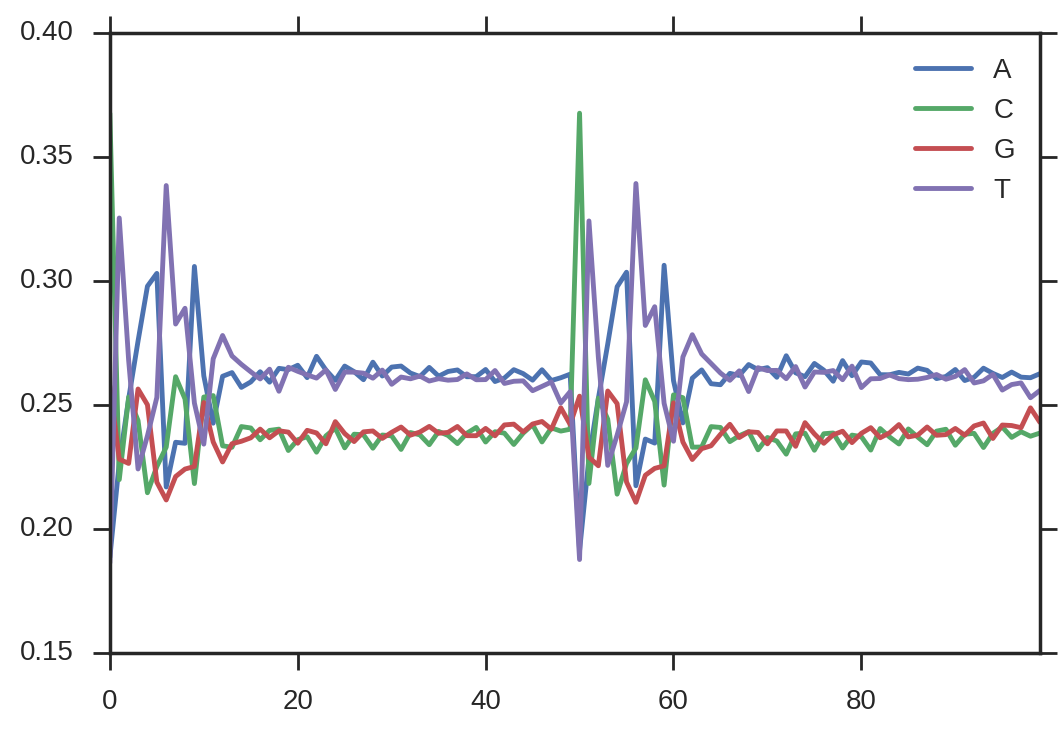

In [350]:
freqs_df.plot()

In [305]:
lump_stats.head()

,tag,centrality,position,pair,degree,kmer_f,kmer_r
0,0,-8.664243,73,R,8,AAAAAAAAAAAAAAAAAAAAAAAAA,TTTTTTTTTTTTTTTTTTTTTTTTT
1,0,-8.664243,74,R,8,AAAAAAAAAAAAAAAAAAAAAAAAA,TTTTTTTTTTTTTTTTTTTTTTTTT
2,0,-8.664243,75,R,8,AAAAAAAAAAAAAAAAAAAAAAAAA,TTTTTTTTTTTTTTTTTTTTTTTTT
3,0,-8.664243,0,L,8,AAAAAAAAAAAAAAAAAAAAAAAAA,TTTTTTTTTTTTTTTTTTTTTTTTT
4,0,-8.664243,50,R,8,AAAAAAAAAAAAAAAAAAAAAAAAA,TTTTTTTTTTTTTTTTTTTTTTTTT


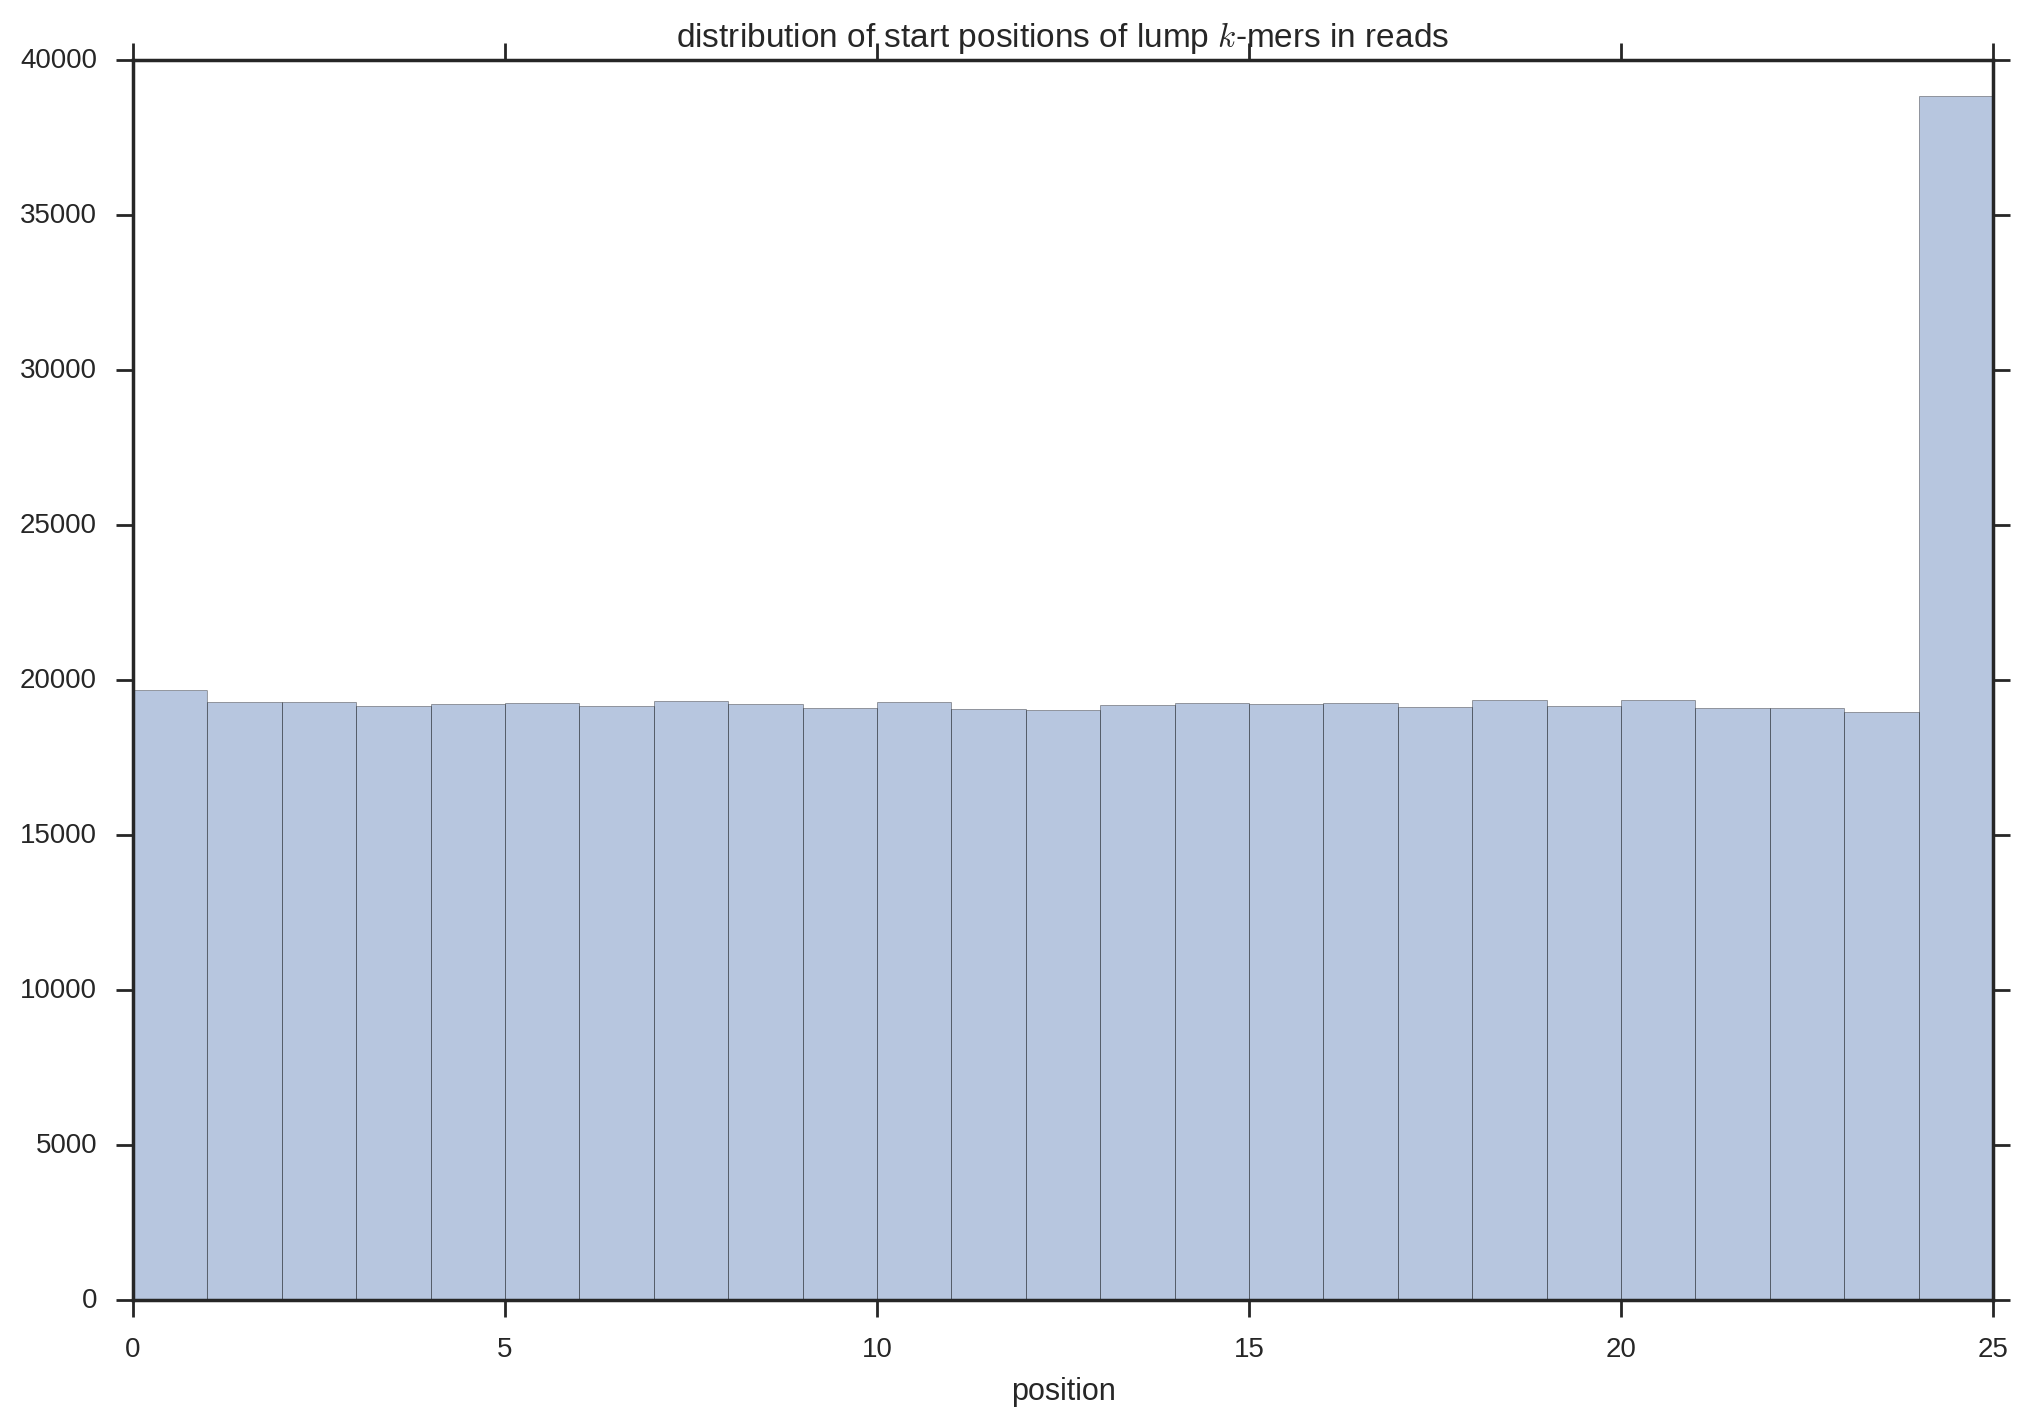

In [276]:
figsize(12,8)
sns.distplot(lump_stats.query('pair == "L"').sample(n=500000)['position'], kde=False, bins=25)
title('distribution of start positions of lump $k$-mers in reads', )

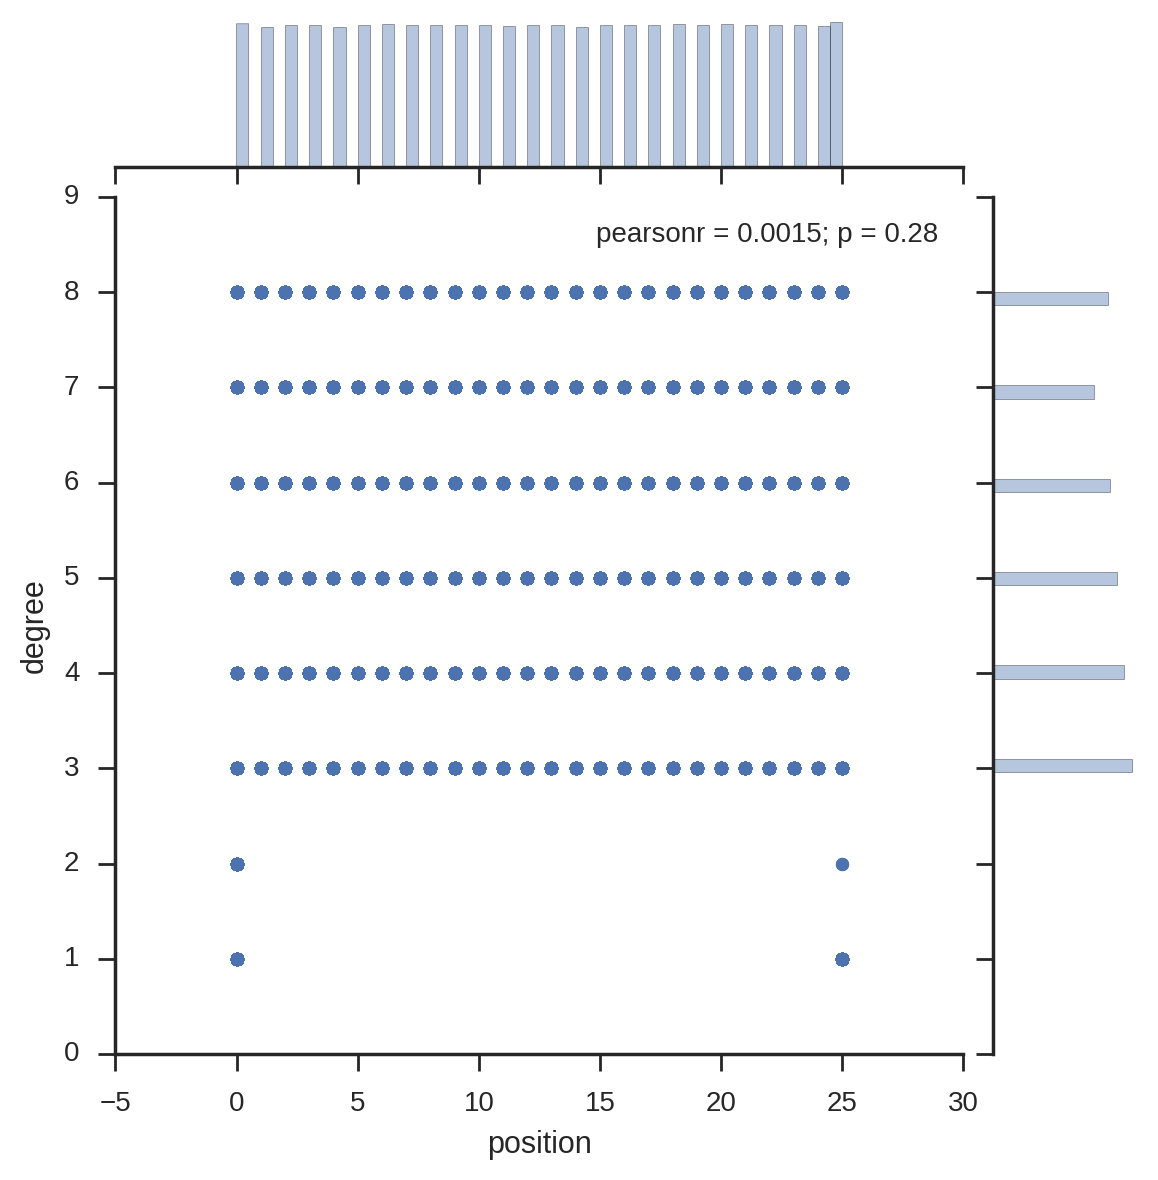

In [272]:
sns.jointplot(x='position', y='degree', data=lump_stats.sample(n=1000000).query('pair == "L"'))

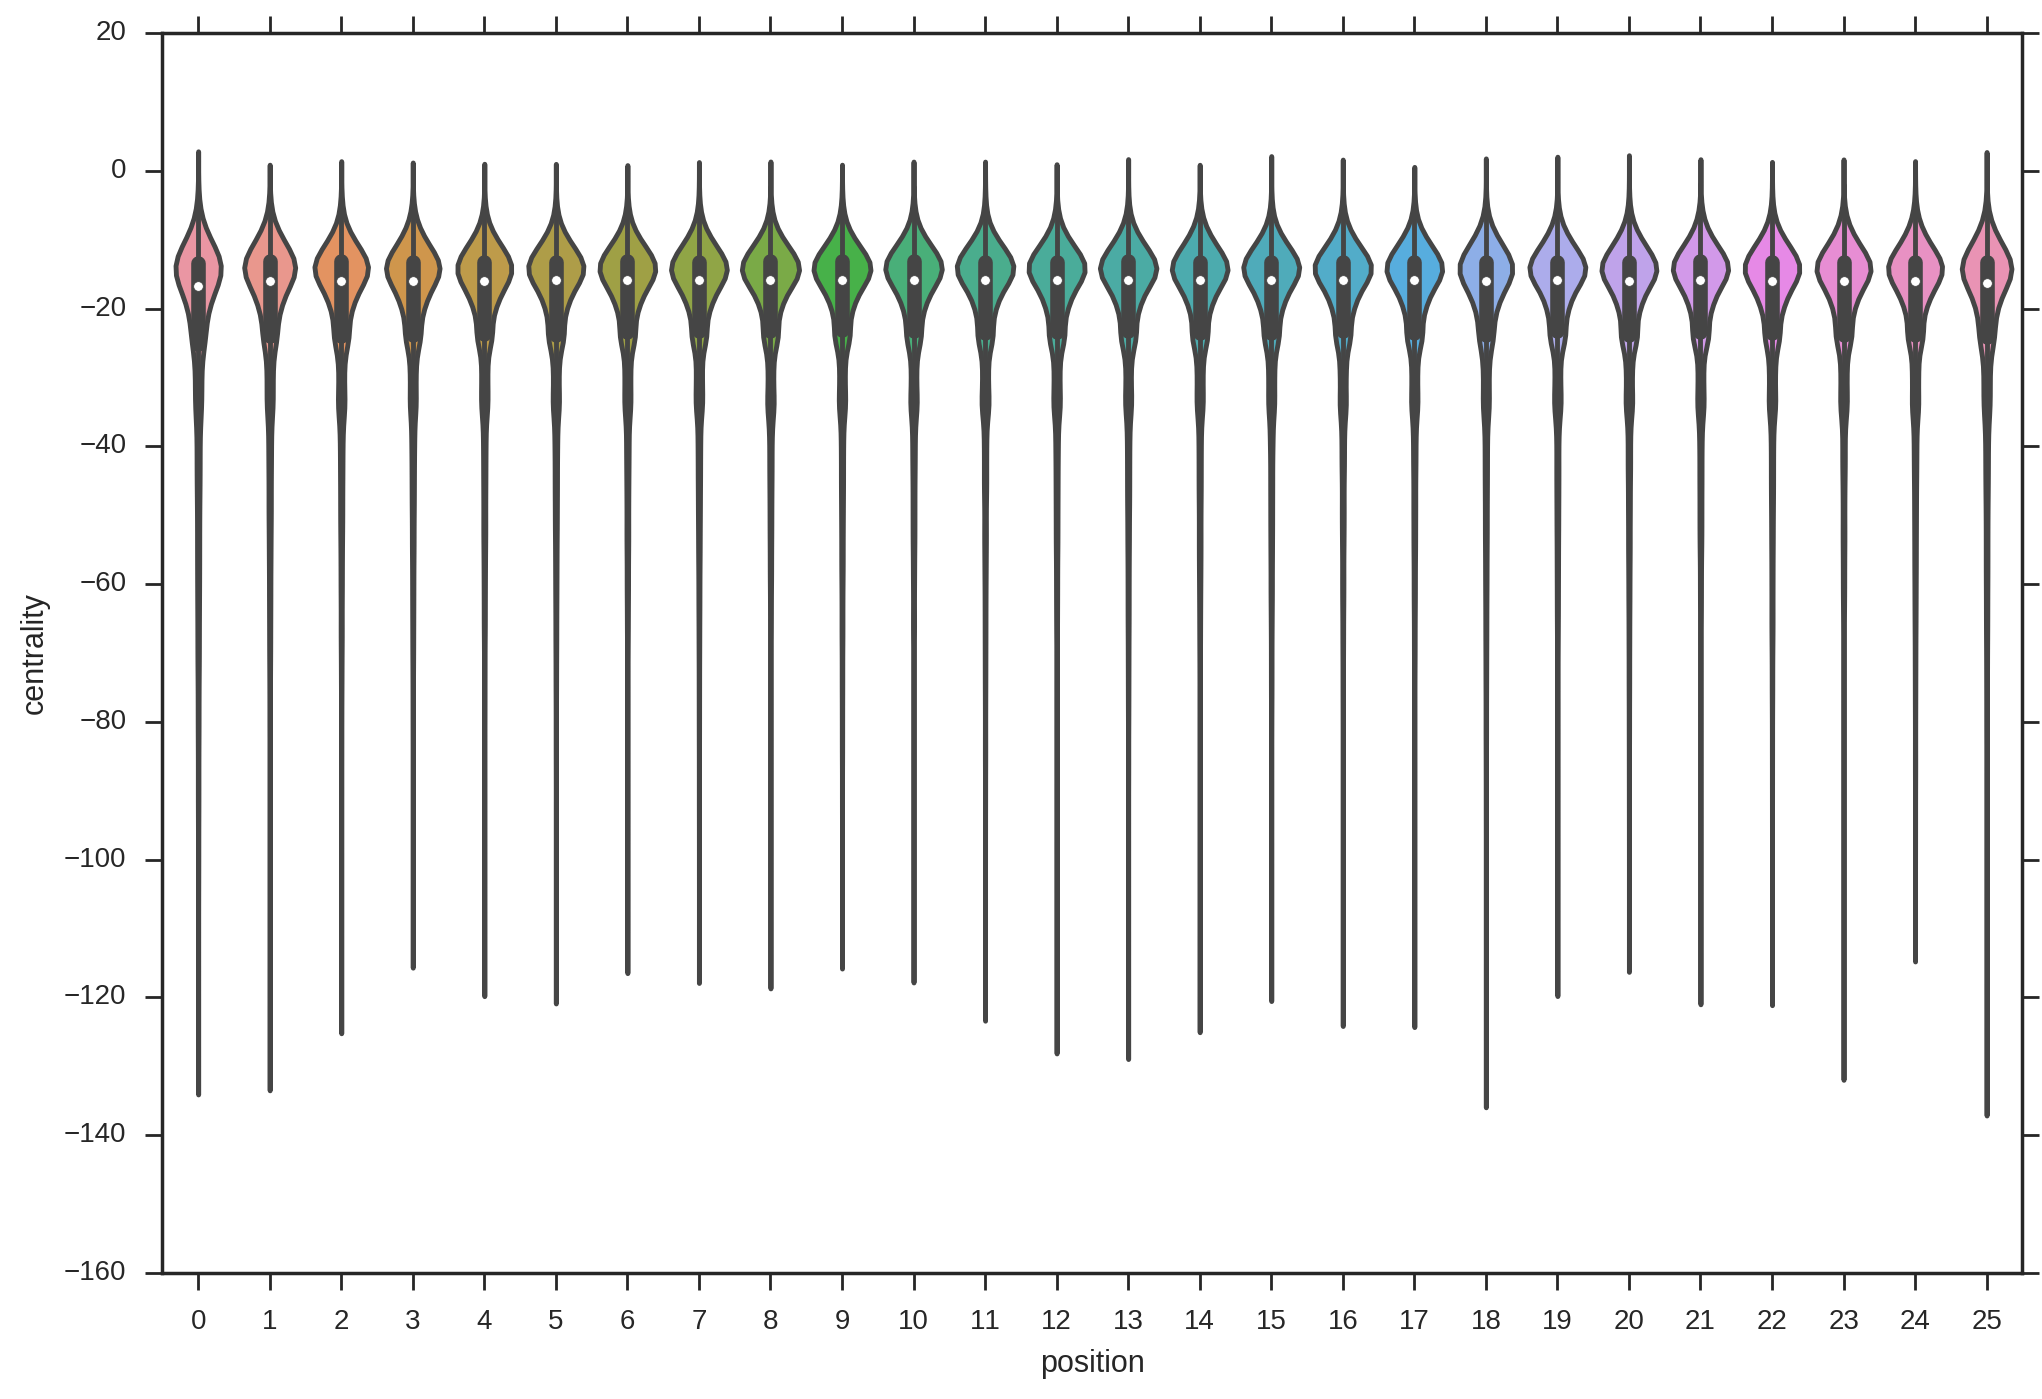

In [290]:
sns.violinplot(x='position', y='centrality', data=lump_stats.sample(n=1000000).query('pair == "L"'))

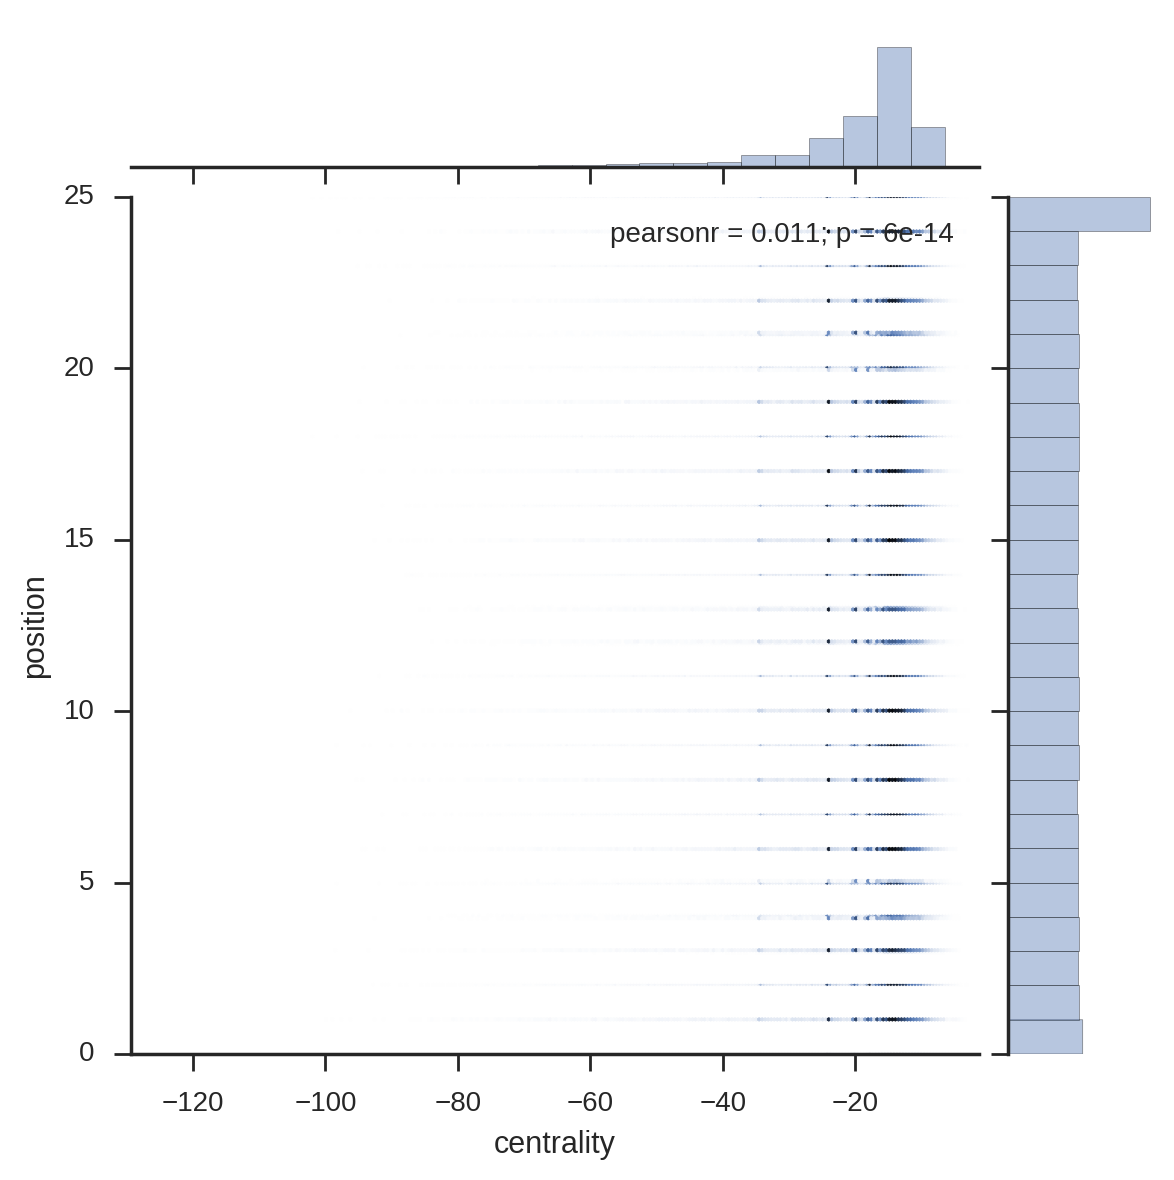

In [291]:
sns.jointplot('centrality', 'position', lump_stats.sample(n=1000000).query('pair == "L"'), kind='hexbin', 
              marginal_kws={'bins': 25})

In [223]:
lump_stats = pd.concat([lump_centrality.centrality, lump_avg_pos], axis=1)
lump_stats.rename(columns={0:'avg_pos'}, inplace=True)
lump_stats.dropna(inplace=True)


/home/camille/miniconda/envs/dev.py3.khmer.assembly/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


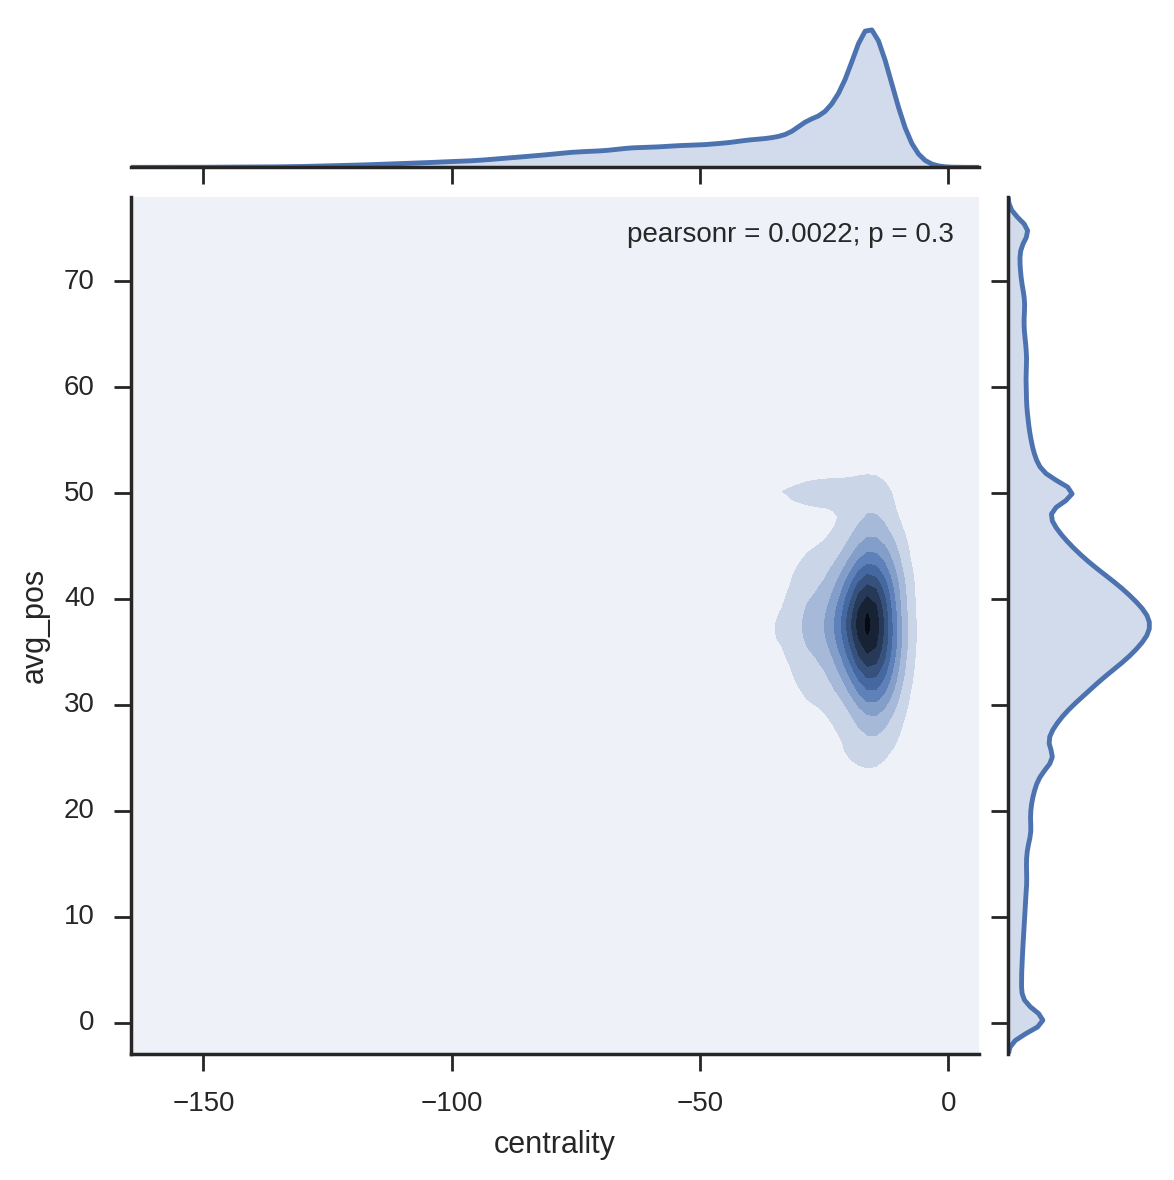

In [227]:
sns.jointplot('centrality', 'avg_pos', data=lump_stats, kind='kde')

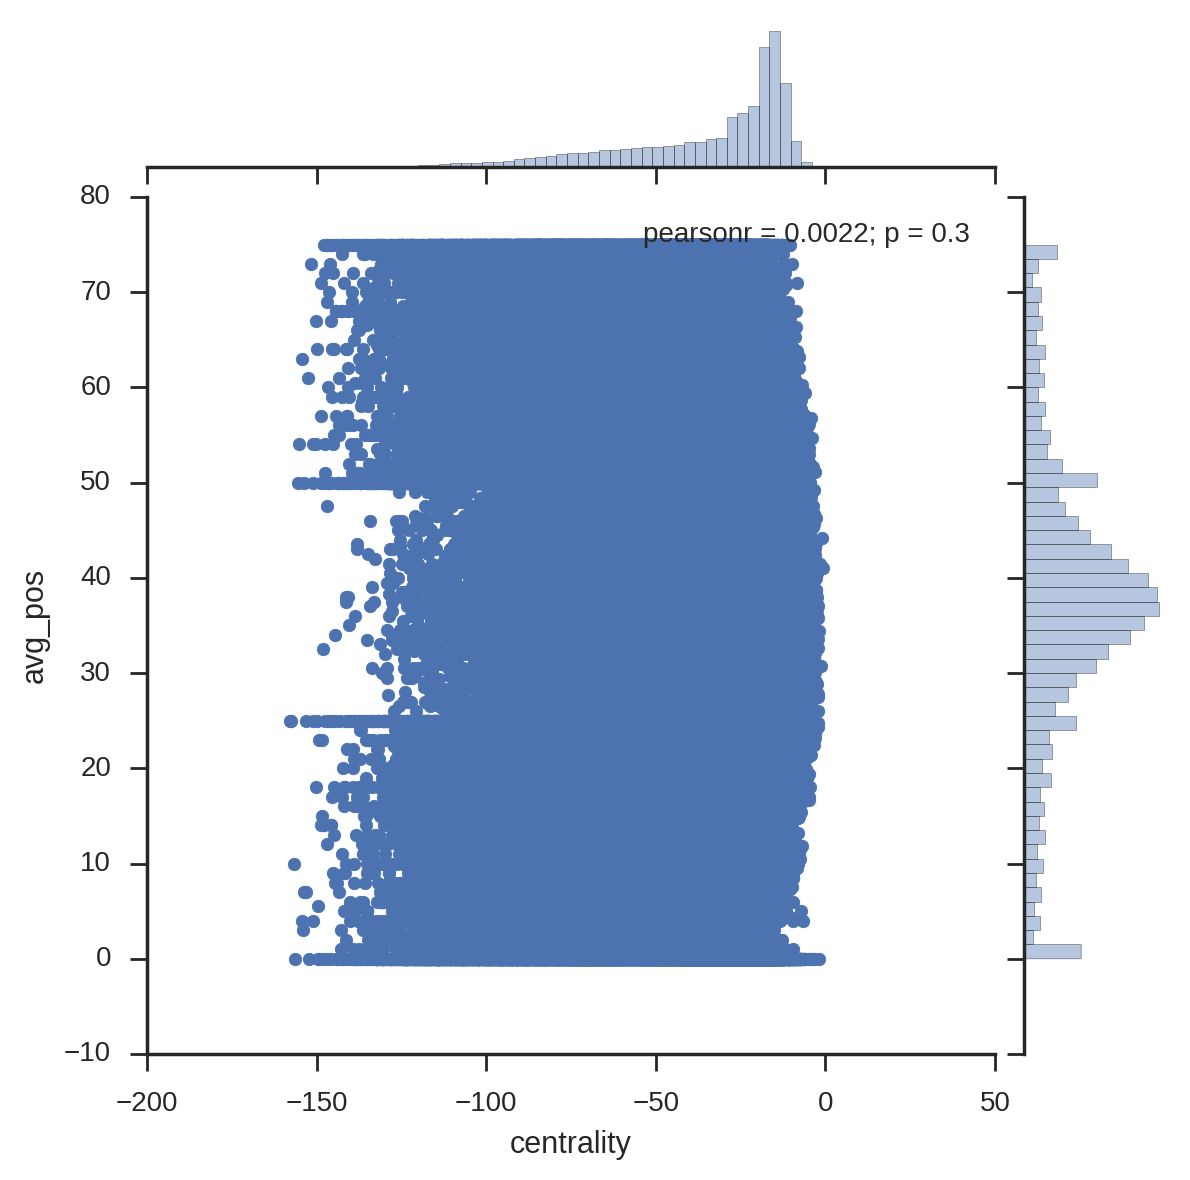

In [228]:
sns.jointplot('centrality', 'avg_pos', data=lump_stats)